In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
from scipy.io import loadmat
from skimage import io
import spectral

In [2]:
img = loadmat(r"C:\Users\ursti\Downloads\GAN\Datasets\PaviaU\PaviaU.mat")['paviaU']
gt = loadmat(r"C:\Users\ursti\Downloads\GAN\Datasets\PaviaU\PaviaU_gt.mat")['paviaU_gt']

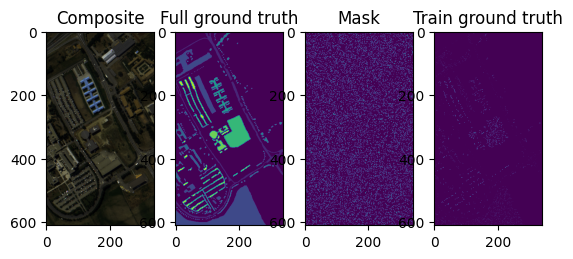

In [3]:
mask = np.random.randint(0, 100, gt.shape) < 5
train_gt = np.copy(gt)
train_gt[np.nonzero(~mask)] = 0
test_gt = np.copy(gt)
test_gt[train_gt > 0] = 0

rgb = img[:,:,(55,41,12)]
rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
fig = plt.figure()
fig.add_subplot(141)
plt.imshow(rgb)
plt.title("Composite")
fig.add_subplot(142)
plt.imshow(gt)
plt.title("Full ground truth")
fig.add_subplot(143)
plt.imshow(mask)
plt.title("Mask")
fig.add_subplot(144)
plt.imshow(train_gt)
plt.title("Train ground truth")
plt.show()

In [4]:
from skimage import morphology

class HyperX(torch.utils.data.Dataset):
    
    def __init__(self, data, ground_truth, semi=False):
        super(HyperX, self).__init__()
        # Normalize the data in [0,1]
        data = (data - data.min()) / (data.max() - data.min())
        self.data = data
        self.gt = ground_truth
        self.n_classes = len(np.unique(ground_truth))
        if semi:
            # Semi-supervision, include neighbours at 50px
            x_pos, y_pos = np.nonzero(morphology.dilation(ground_truth > 0, morphology.disk(50)))
        else:
            x_pos, y_pos = np.nonzero(ground_truth)
        self.indices = [idx for idx in zip(x_pos, y_pos)]
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, i):
        x, y = self.indices[i]
        data = self.data[x,y]
        # Get the label in one-hot encoded style
        label = np.asarray(np.eye(self.n_classes)[self.gt[x, y]], dtype='int64')
        return torch.from_numpy(data), torch.from_numpy(label)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

        
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(z_dim + c_dim, h_dim),
            nn.SELU(),
            nn.Linear(h_dim, h_dim),
            nn.SELU(),
            nn.Linear(h_dim, h_dim),
            nn.SELU(),
            nn.Linear(h_dim, h_dim),
            nn.SELU(),
            nn.Linear(h_dim, h_dim),
            nn.SELU(),
            nn.Linear(h_dim, X_dim),
            nn.Sigmoid()
        )
        self.apply(weight_init)

    def forward(self, z, c):
        inputs = torch.cat([z, c], dim=1)
        return self.generator(inputs)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, 1)
        )
        self.apply(weight_init)

    def forward(self, x):
        return self.discriminator(x)
    
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.BatchNorm1d(h_dim),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, c_dim)
        )
        self.apply(weight_init)

    def forward(self, x):
        return self.classifier(x)


In [6]:
mb_size = 256 # Batch size
z_dim = 30   # Noise dimension
X_dim = img.shape[-1] # Number of bands
h_dim = 512  # Hidden layer size
d_step = 5   # Number of discriminator training steps for each generator training step
lr = 5e-5    # Learning rate
c_weight = 0.2 # Auxiliary classifier weight
flip_percentage = 0.0 # Proportion of label flipping
mixup_alpha = 0.1 # Mixup
semi_supervised = True # semi-supervision (set to True to include unlabeled samples)

# Build the dataset and data loader
data_loader = torch.utils.data.DataLoader(
    HyperX(img, train_gt if semi_supervised else gt), batch_size=mb_size, shuffle=True)
# c_dim = condition vector size
c_dim = data_loader.dataset.n_classes

# Ignore the class 0
class_weights = torch.ones((c_dim))
class_weights[0] = 0.
class_weights = class_weights.cuda()

In [7]:
# Initialize weights using the He et al. (2015) policy.
def weight_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.Conv3d, nn.ConvTranspose3d)):
        torch.nn.init.kaiming_normal_(m.weight.data)

# Spherical interpolation between two vectors on the unit hypersphere
# See : https://github.com/soumith/dcgan.torch/issues/14
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high # L'Hopital's rule/LERP
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

def lerp(val, low, high):
    return (1.0-val) * low + val * high # L'Hopital's rule/LERP

# Gradient penalty from the Improved WGAN training
# From : https://github.com/EmilienDupont/wgan-gp
# Use penalty_weight set at 10, as suggested in the paper
def calc_gradient_penalty(netD, real_data, generated_data, penalty_weight=10):
        batch_size = real_data.size()[0]

        alpha = torch.rand(batch_size, 1) if real_data.dim() == 2 else torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        alpha = alpha.cuda()
        
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        #interpolated = Variable(interpolated, requires_grad=True)
        interpolated.requires_grad_()
        interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = netD(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return penalty_weight * ((gradients_norm - 1) ** 2).mean()
    
def reset_grad(*nets):
    for net in nets:
        net.zero_grad()
        
def plot_mean_std(samples):
    mean_spectrum = np.mean(samples, axis=0)
    std_spectrum = np.std(samples, axis=0)
    plt.plot(mean_spectrum - std_spectrum, linestyle='dotted', label='-std')
    plt.plot(mean_spectrum, label='mean')
    plt.plot(mean_spectrum + std_spectrum, linestyle='dotted', label='+std')

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]C:\Users\ursti\AppData\Local\Temp\ipykernel_8572\1864507184.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.log_softmax(C(X))


Iter-0; D_loss: 0.28274857997894287; G_loss: 0.7262037992477417; C_loss: 3.0537476539611816


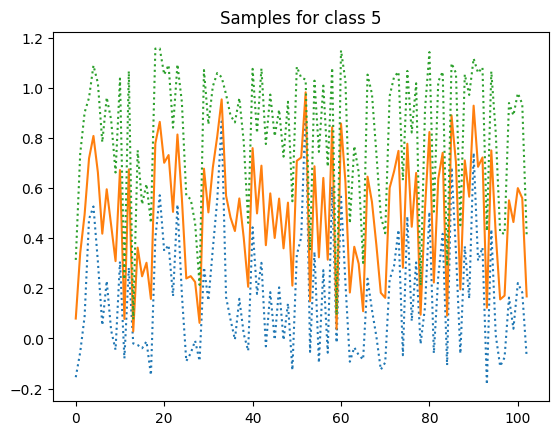

  1%|▋                                                                         | 1000/100000 [02:44<5:06:40,  5.38it/s]

Iter-1000; D_loss: -0.1850329339504242; G_loss: 1.0389559268951416; C_loss: 0.26379644870758057


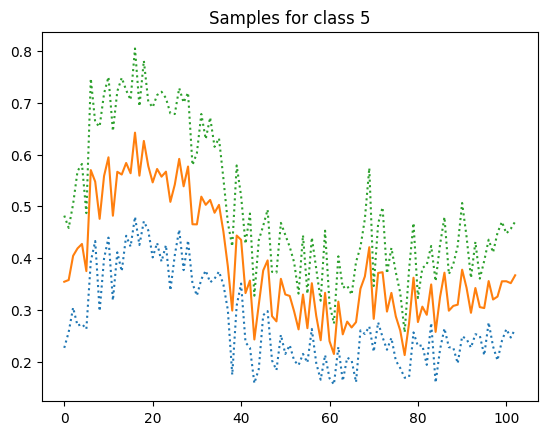

  2%|█▍                                                                        | 2000/100000 [05:41<6:14:49,  4.36it/s]

Iter-2000; D_loss: 0.12330007553100586; G_loss: -0.8652580976486206; C_loss: 0.10571800917387009


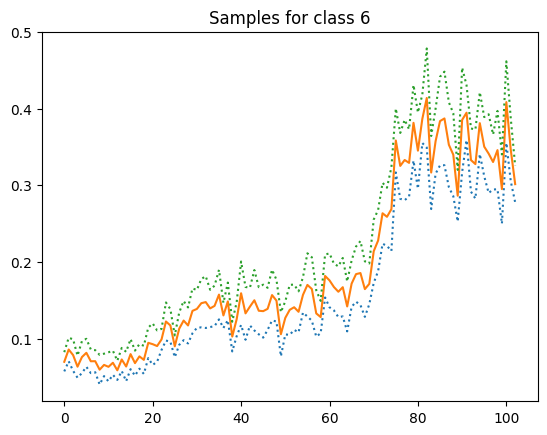

  3%|██▏                                                                       | 3000/100000 [08:30<4:21:25,  6.18it/s]

Iter-3000; D_loss: -0.01952364109456539; G_loss: -1.4560306072235107; C_loss: 0.07231096178293228


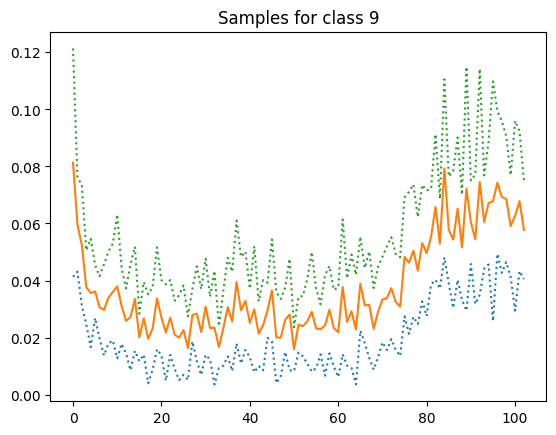

  4%|██▉                                                                       | 4000/100000 [11:21<5:50:59,  4.56it/s]

Iter-4000; D_loss: -0.03738393262028694; G_loss: -1.5880496501922607; C_loss: 0.06303147971630096


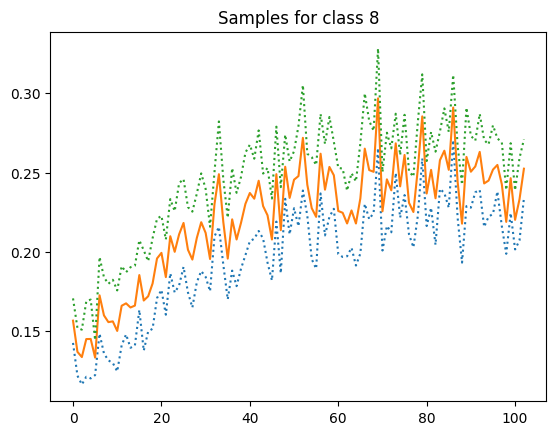

  5%|███▋                                                                      | 5000/100000 [14:21<8:08:58,  3.24it/s]

Iter-5000; D_loss: -0.016368750482797623; G_loss: -1.7665817737579346; C_loss: 0.07039251178503036


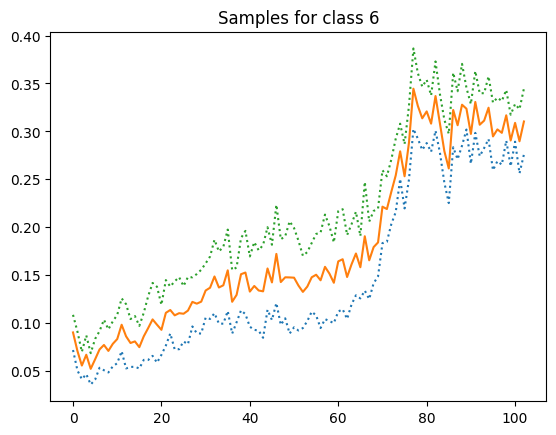

  6%|████▍                                                                     | 6000/100000 [17:49<3:59:30,  6.54it/s]

Iter-6000; D_loss: -0.06302150338888168; G_loss: -1.67681884765625; C_loss: 0.06164151057600975


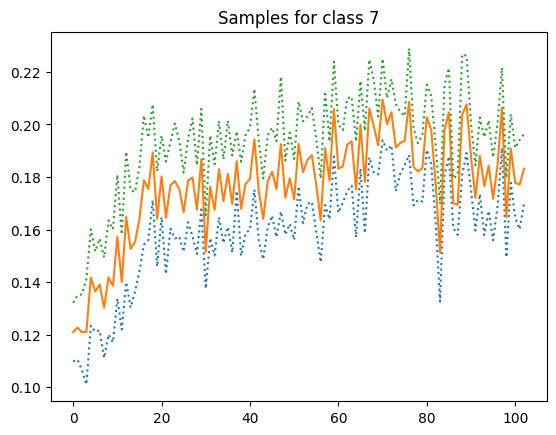

  7%|█████▏                                                                    | 7000/100000 [20:37<3:42:18,  6.97it/s]

Iter-7000; D_loss: -0.04427805542945862; G_loss: -1.8437163829803467; C_loss: 0.05759568139910698


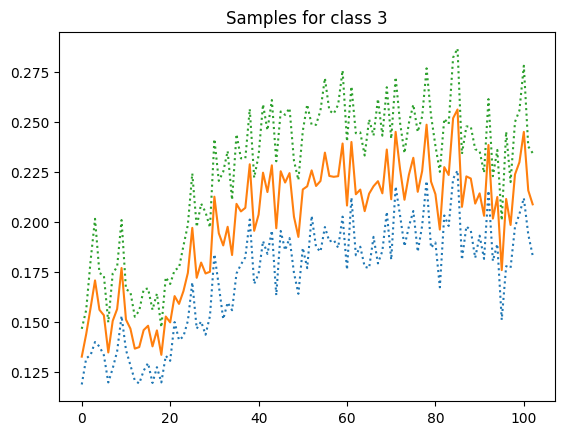

  8%|█████▉                                                                    | 8000/100000 [23:37<4:04:12,  6.28it/s]

Iter-8000; D_loss: -0.078030064702034; G_loss: -1.6721272468566895; C_loss: 0.08368708938360214


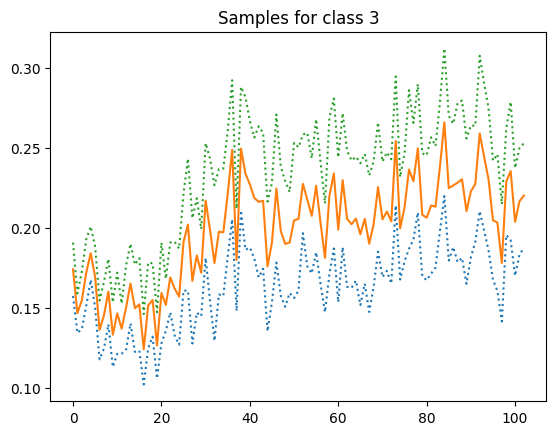

  9%|██████▋                                                                   | 9000/100000 [26:27<3:49:13,  6.62it/s]

Iter-9000; D_loss: -0.020495247095823288; G_loss: -1.1855956315994263; C_loss: 0.0523277148604393


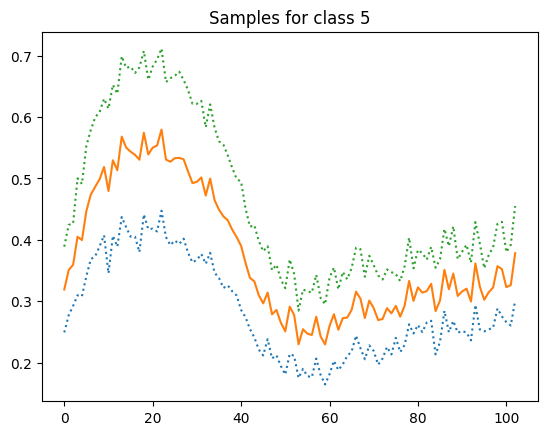

 10%|███████▎                                                                 | 10000/100000 [29:17<4:23:42,  5.69it/s]

Iter-10000; D_loss: -0.014054052531719208; G_loss: -0.9589838981628418; C_loss: 0.022551774978637695


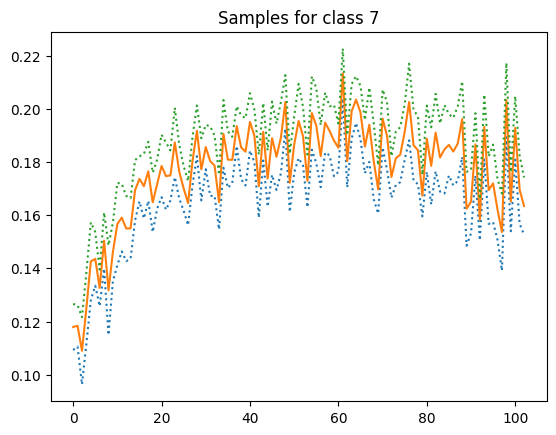

 11%|████████                                                                 | 11000/100000 [32:10<3:24:06,  7.27it/s]

Iter-11000; D_loss: -0.03236151486635208; G_loss: -1.0156500339508057; C_loss: 0.11898840963840485


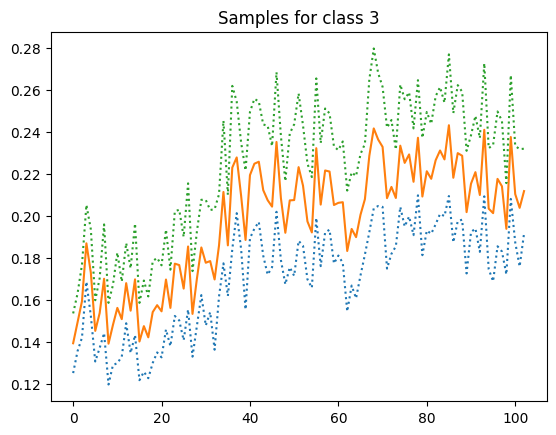

 12%|████████▊                                                                | 12000/100000 [35:56<8:11:06,  2.99it/s]

Iter-12000; D_loss: -0.011303046718239784; G_loss: -1.0901345014572144; C_loss: 0.04115727171301842


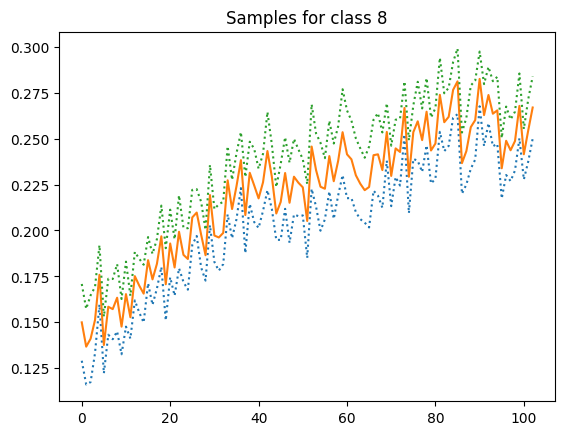

 13%|█████████▍                                                               | 13000/100000 [41:01<7:57:56,  3.03it/s]

Iter-13000; D_loss: -0.031629011034965515; G_loss: -0.7431923151016235; C_loss: 0.037734102457761765


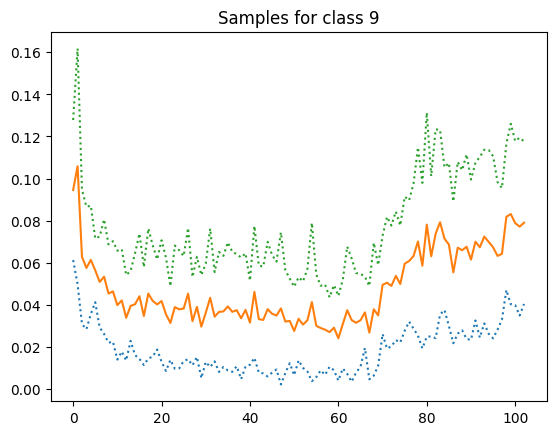

 14%|██████████▏                                                              | 14000/100000 [44:38<4:31:54,  5.27it/s]

Iter-14000; D_loss: -0.03323931246995926; G_loss: -0.8082077503204346; C_loss: 0.03955232724547386


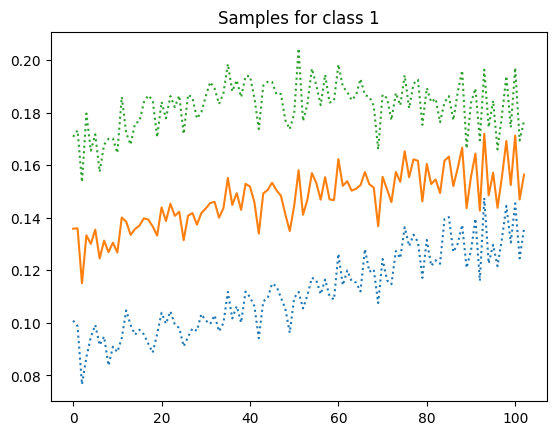

 15%|██████████▉                                                              | 15000/100000 [47:26<3:15:35,  7.24it/s]

Iter-15000; D_loss: -0.006540019065141678; G_loss: -1.1341007947921753; C_loss: 0.044005218893289566


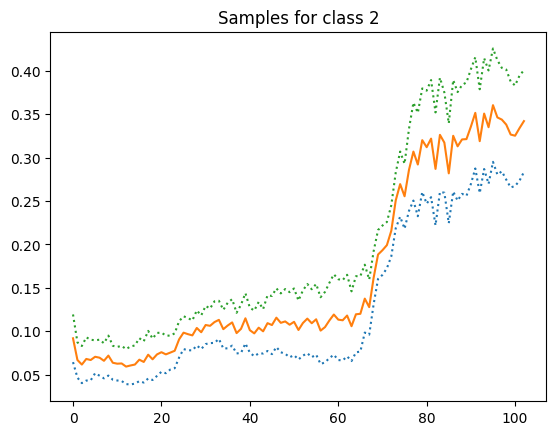

 16%|███████████▋                                                             | 16000/100000 [51:00<3:13:09,  7.25it/s]

Iter-16000; D_loss: -0.011681577190756798; G_loss: -0.9323064088821411; C_loss: 0.03398483246564865


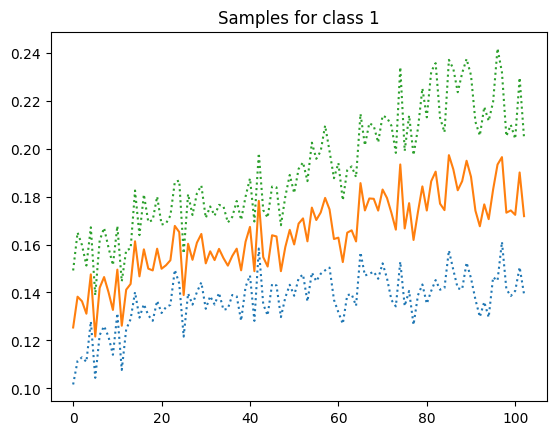

 17%|████████████▍                                                            | 17000/100000 [53:48<4:12:57,  5.47it/s]

Iter-17000; D_loss: 0.009934253990650177; G_loss: -0.7860590815544128; C_loss: 0.020453719422221184


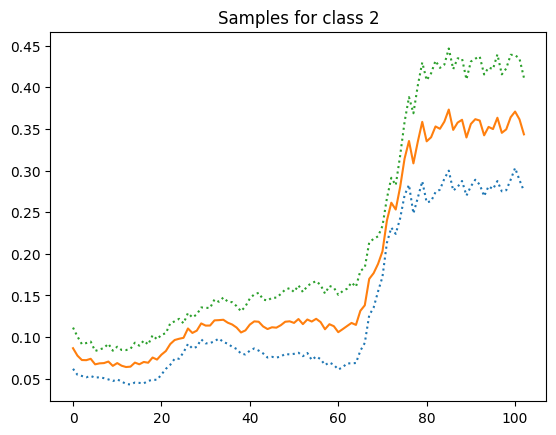

 18%|█████████████▏                                                           | 18000/100000 [56:35<4:03:02,  5.62it/s]

Iter-18000; D_loss: -0.03658413887023926; G_loss: -0.6373721361160278; C_loss: 0.022195668891072273


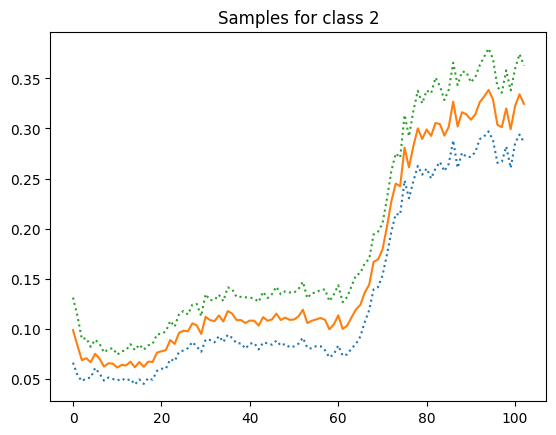

 19%|█████████████▊                                                           | 19000/100000 [59:36<3:32:12,  6.36it/s]

Iter-19000; D_loss: -0.002954348921775818; G_loss: -0.7410812377929688; C_loss: 0.04446837306022644


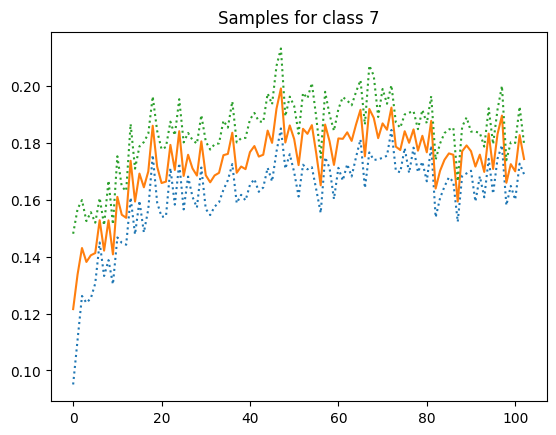

 20%|██████████████▏                                                        | 20000/100000 [1:02:28<3:59:48,  5.56it/s]

Iter-20000; D_loss: -0.02364879846572876; G_loss: -0.5288501381874084; C_loss: 0.026751596480607986


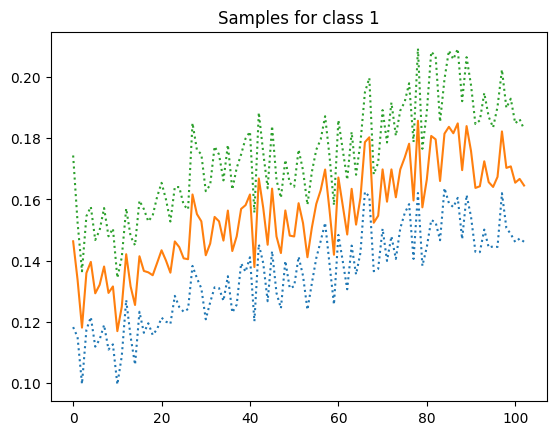

 21%|██████████████▉                                                        | 21000/100000 [1:05:14<3:19:18,  6.61it/s]

Iter-21000; D_loss: 0.002117745578289032; G_loss: -0.49026334285736084; C_loss: 0.013473313301801682


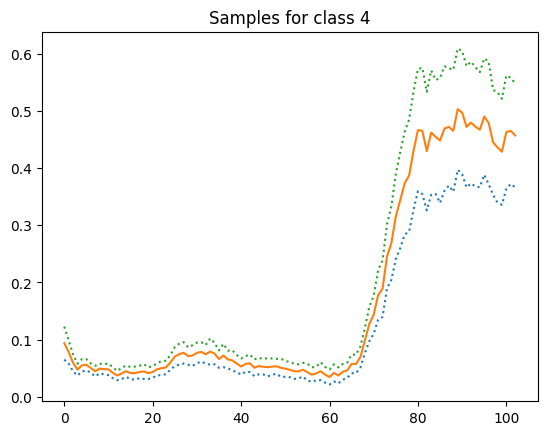

 22%|███████████████▌                                                       | 22000/100000 [1:08:03<3:43:02,  5.83it/s]

Iter-22000; D_loss: 0.021928735077381134; G_loss: -0.6021252870559692; C_loss: 0.06400458514690399


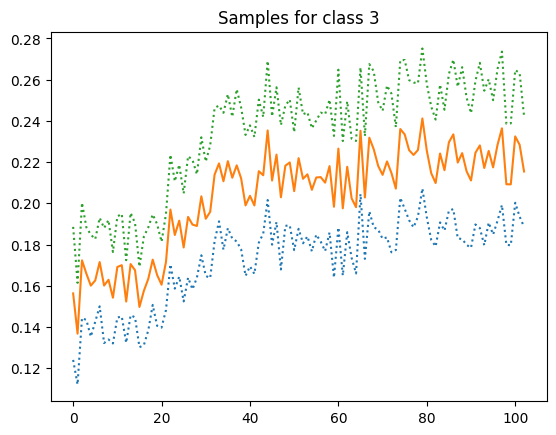

 23%|████████████████▎                                                      | 23000/100000 [1:10:52<3:31:51,  6.06it/s]

Iter-23000; D_loss: -0.023338237777352333; G_loss: -0.2902917265892029; C_loss: 0.019107557833194733


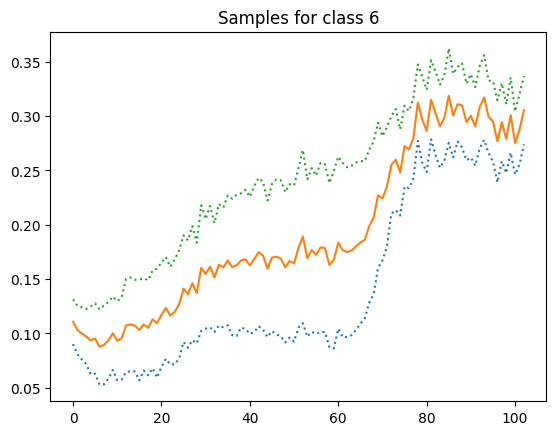

 24%|█████████████████                                                      | 24000/100000 [1:13:43<3:45:50,  5.61it/s]

Iter-24000; D_loss: -0.02266845665872097; G_loss: -0.5848337411880493; C_loss: 0.06471192091703415


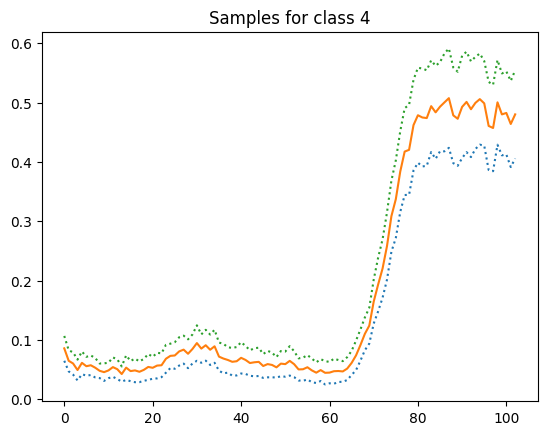

 25%|█████████████████▊                                                     | 25000/100000 [1:16:33<3:38:46,  5.71it/s]

Iter-25000; D_loss: -0.021685246378183365; G_loss: -0.3440212309360504; C_loss: 0.007717150263488293


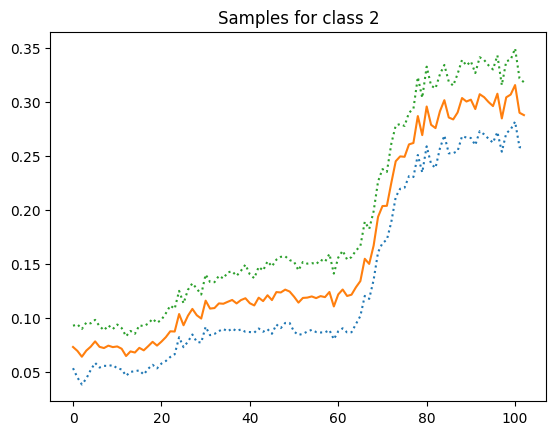

 26%|██████████████████▍                                                    | 26000/100000 [1:19:21<3:45:47,  5.46it/s]

Iter-26000; D_loss: -0.037195246666669846; G_loss: -0.317007839679718; C_loss: 0.017032476142048836


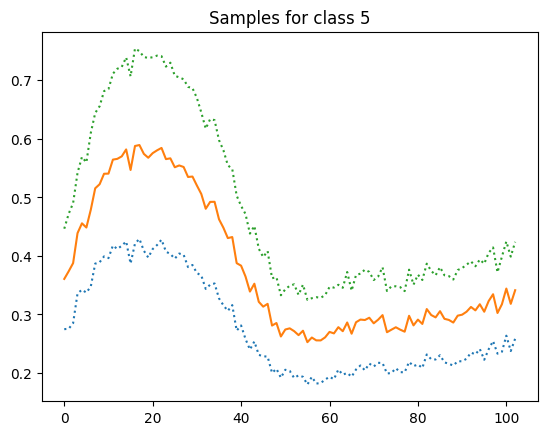

 27%|███████████████████▏                                                   | 27000/100000 [1:22:13<3:58:47,  5.10it/s]

Iter-27000; D_loss: -0.010179806500673294; G_loss: -0.4183602035045624; C_loss: 0.024423468858003616


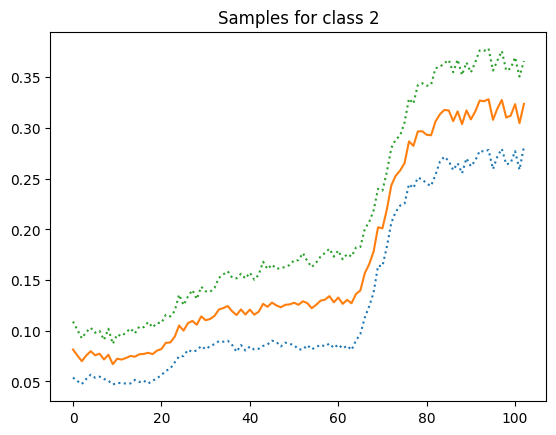

 28%|███████████████████▉                                                   | 28000/100000 [1:25:02<3:29:13,  5.74it/s]

Iter-28000; D_loss: 0.00015492457896471024; G_loss: -0.4285658001899719; C_loss: 0.014327025040984154


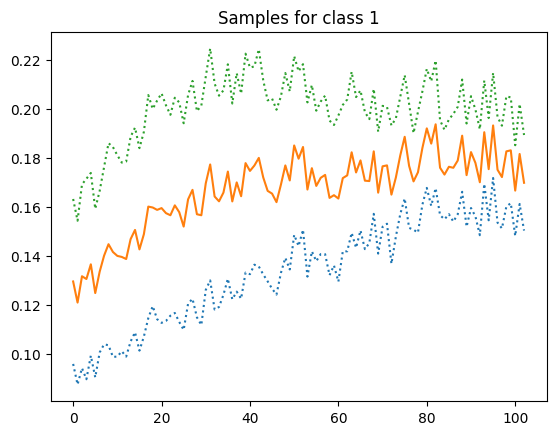

 29%|████████████████████▌                                                  | 29000/100000 [1:28:08<5:53:12,  3.35it/s]

Iter-29000; D_loss: -0.06427771598100662; G_loss: -0.48580202460289; C_loss: 0.010457613505423069


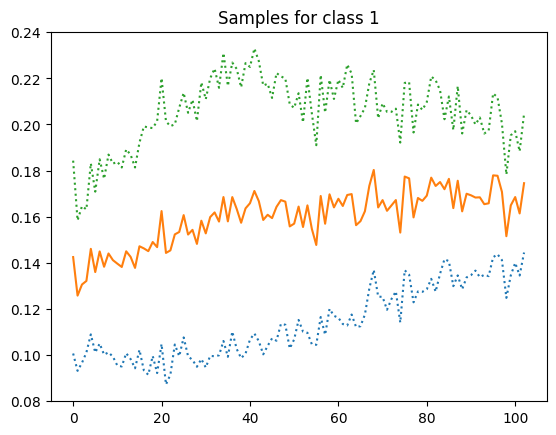

 30%|█████████████████████▎                                                 | 30000/100000 [1:31:58<4:27:01,  4.37it/s]

Iter-30000; D_loss: -0.027780823409557343; G_loss: -0.31330519914627075; C_loss: 0.012371212244033813


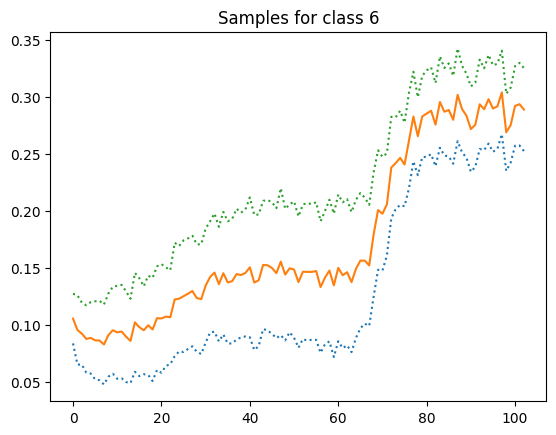

 31%|██████████████████████                                                 | 31000/100000 [1:34:54<2:55:02,  6.57it/s]

Iter-31000; D_loss: -0.03457437455654144; G_loss: -0.4263530671596527; C_loss: 0.03680276870727539


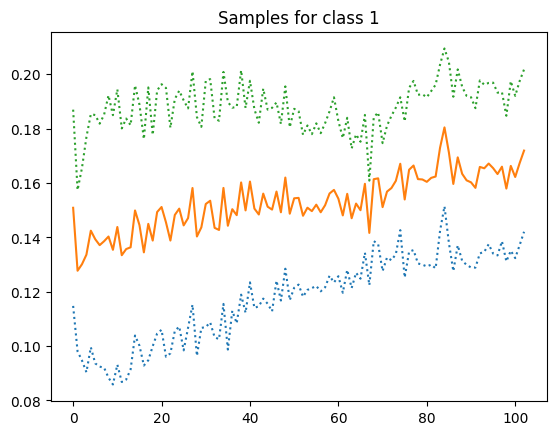

 32%|██████████████████████▋                                                | 32000/100000 [1:37:43<3:04:25,  6.15it/s]

Iter-32000; D_loss: -0.024821409955620766; G_loss: -0.34380191564559937; C_loss: 0.03925999626517296


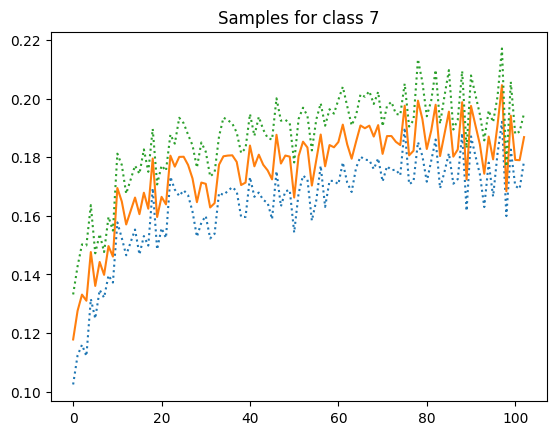

 33%|███████████████████████▍                                               | 33000/100000 [1:40:31<2:35:34,  7.18it/s]

Iter-33000; D_loss: -0.012823827564716339; G_loss: -0.35441070795059204; C_loss: 0.03742518275976181


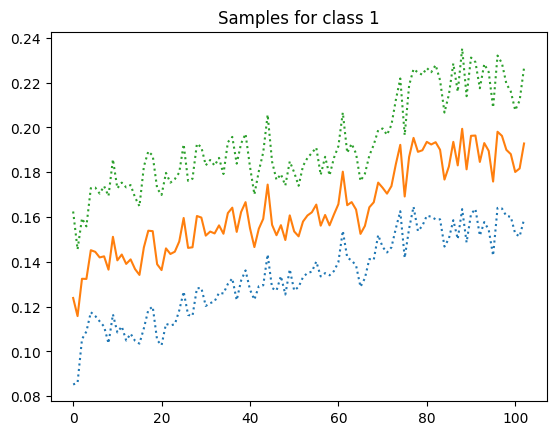

 34%|████████████████████████▏                                              | 34000/100000 [1:43:22<2:51:51,  6.40it/s]

Iter-34000; D_loss: 0.001268237829208374; G_loss: -0.41724276542663574; C_loss: 0.10922708362340927


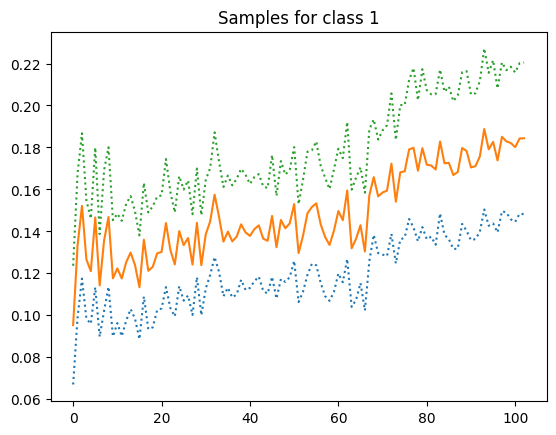

 35%|████████████████████████▊                                              | 35000/100000 [1:46:12<3:45:15,  4.81it/s]

Iter-35000; D_loss: -0.018099501729011536; G_loss: -0.5509216785430908; C_loss: 0.05688722804188728


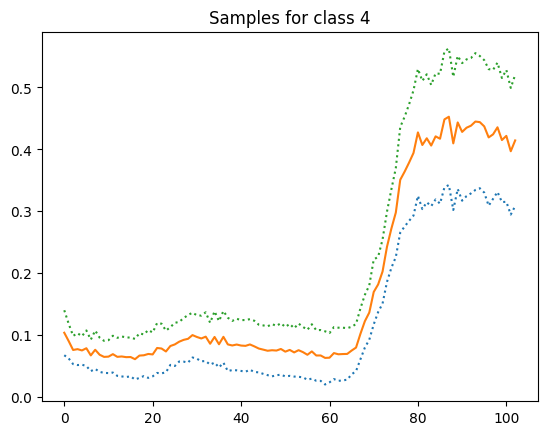

 36%|█████████████████████████▌                                             | 36000/100000 [1:49:00<3:10:58,  5.59it/s]

Iter-36000; D_loss: -0.023268479853868484; G_loss: -0.5356947183609009; C_loss: 0.058438271284103394


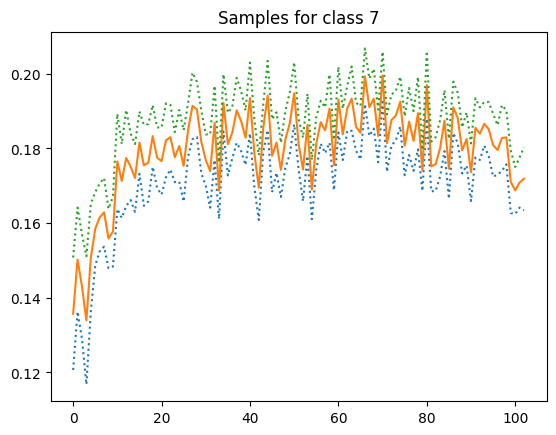

 37%|██████████████████████████▎                                            | 37000/100000 [1:51:49<2:42:46,  6.45it/s]

Iter-37000; D_loss: -0.02287987247109413; G_loss: -0.382485032081604; C_loss: 0.01589931547641754


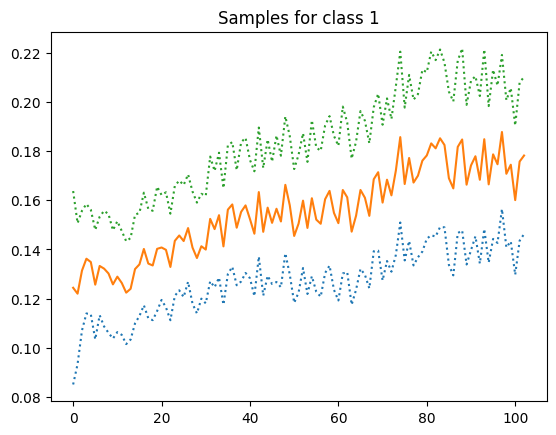

 38%|██████████████████████████▉                                            | 38000/100000 [1:54:38<2:57:15,  5.83it/s]

Iter-38000; D_loss: -0.03676360845565796; G_loss: -0.322937935590744; C_loss: 0.01781853847205639


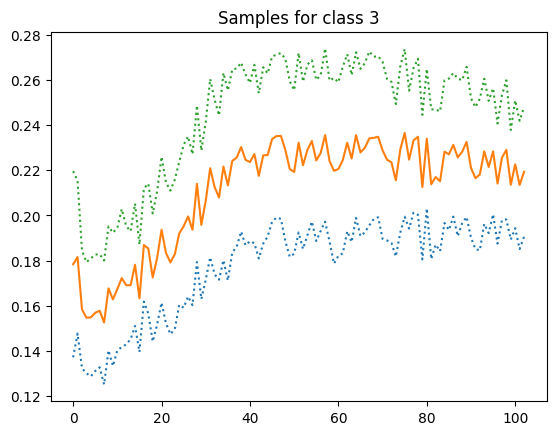

 39%|███████████████████████████▋                                           | 39000/100000 [1:57:28<2:53:43,  5.85it/s]

Iter-39000; D_loss: -0.017196331173181534; G_loss: -0.44710689783096313; C_loss: 0.012156895361840725


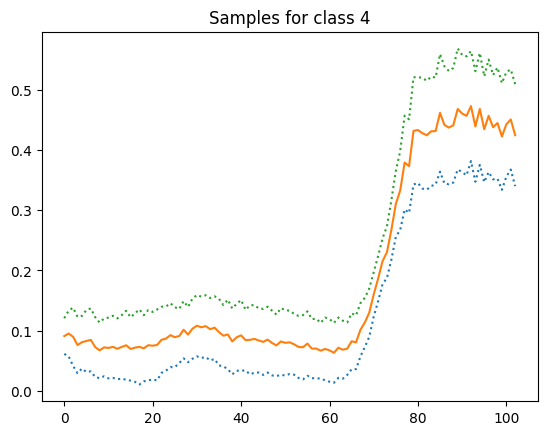

 40%|████████████████████████████▍                                          | 40000/100000 [2:00:16<2:42:14,  6.16it/s]

Iter-40000; D_loss: -0.049575190991163254; G_loss: -0.4373290538787842; C_loss: 0.02884107269346714


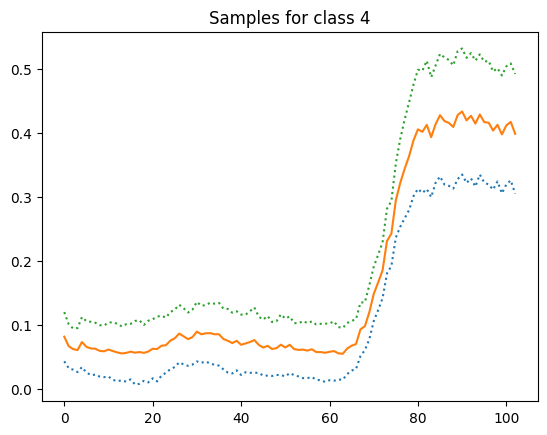

 41%|█████████████████████████████                                          | 41000/100000 [2:03:07<2:49:07,  5.81it/s]

Iter-41000; D_loss: -0.02307550236582756; G_loss: -0.5753163695335388; C_loss: 0.016783475875854492


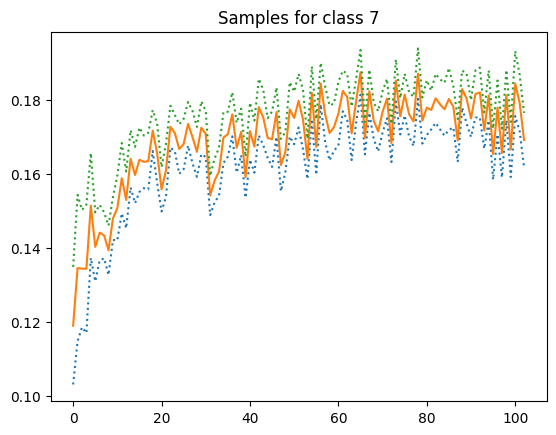

 42%|█████████████████████████████▊                                         | 42000/100000 [2:05:57<2:20:10,  6.90it/s]

Iter-42000; D_loss: 0.010552644729614258; G_loss: -0.5775147676467896; C_loss: 0.031082317233085632


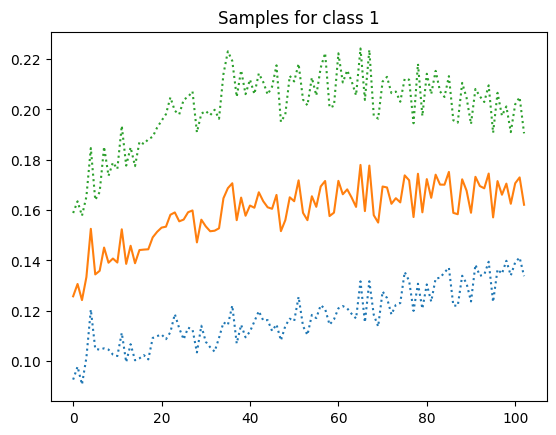

 43%|██████████████████████████████▌                                        | 43000/100000 [2:08:47<2:50:00,  5.59it/s]

Iter-43000; D_loss: -0.024833060801029205; G_loss: -0.38496702909469604; C_loss: 0.012471383437514305


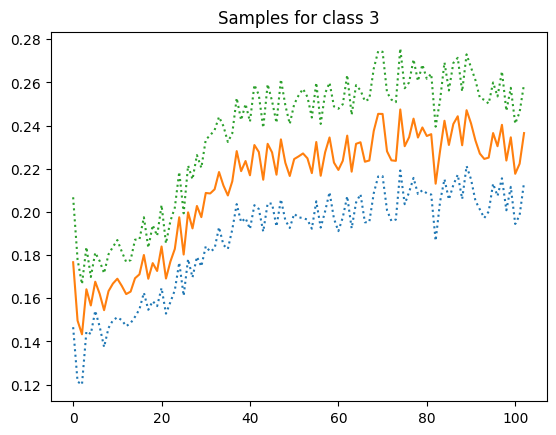

 44%|███████████████████████████████▏                                       | 44000/100000 [2:11:38<2:39:44,  5.84it/s]

Iter-44000; D_loss: 0.009028468281030655; G_loss: -0.42250359058380127; C_loss: 0.015968767926096916


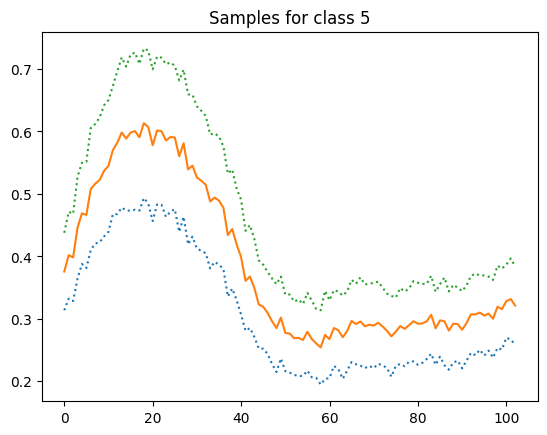

 45%|███████████████████████████████▉                                       | 45000/100000 [2:14:28<2:42:30,  5.64it/s]

Iter-45000; D_loss: -0.0387420728802681; G_loss: -0.5246847867965698; C_loss: 0.008571553975343704


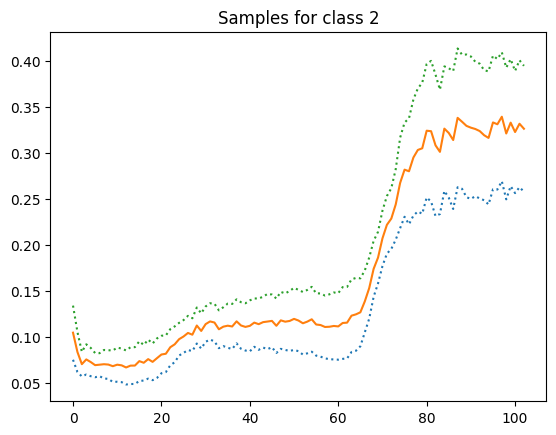

 46%|████████████████████████████████▋                                      | 46000/100000 [2:17:16<2:23:41,  6.26it/s]

Iter-46000; D_loss: -0.061465319246053696; G_loss: -0.45647478103637695; C_loss: 0.03422838822007179


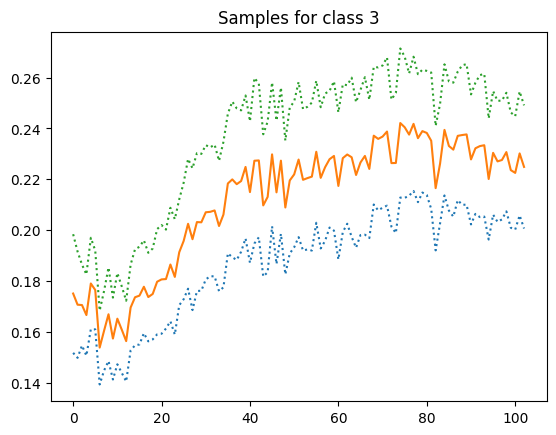

 47%|█████████████████████████████████▎                                     | 47000/100000 [2:20:04<2:34:59,  5.70it/s]

Iter-47000; D_loss: -0.021851245313882828; G_loss: -0.3338671326637268; C_loss: 0.030969399958848953


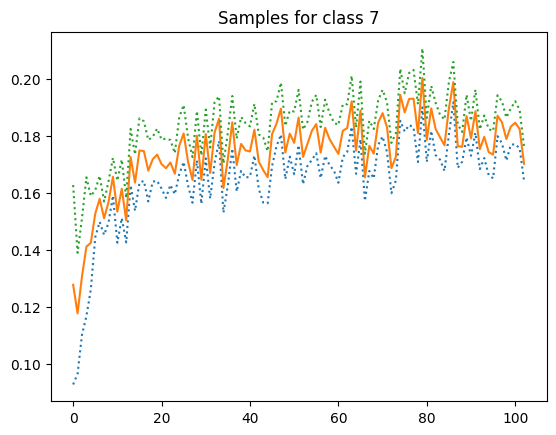

 48%|██████████████████████████████████                                     | 48000/100000 [2:22:54<2:13:45,  6.48it/s]

Iter-48000; D_loss: -0.032729372382164; G_loss: -0.21193827688694; C_loss: 0.010589422658085823


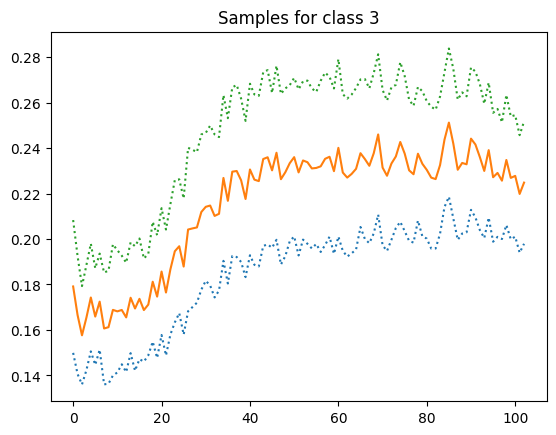

 49%|██████████████████████████████████▊                                    | 49000/100000 [2:25:42<2:26:39,  5.80it/s]

Iter-49000; D_loss: -0.0021111629903316498; G_loss: -0.10940493643283844; C_loss: 0.02079523168504238


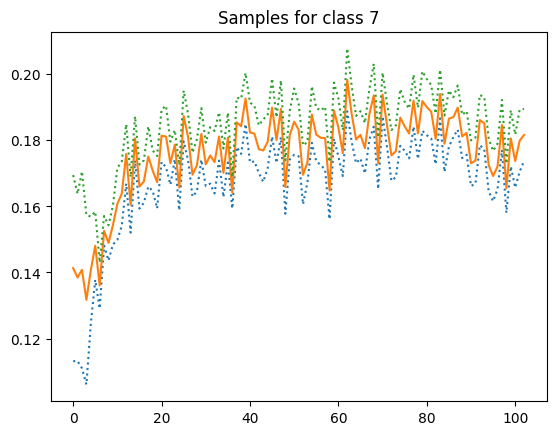

 50%|███████████████████████████████████▌                                   | 50000/100000 [2:28:30<2:23:03,  5.82it/s]

Iter-50000; D_loss: -0.043275751173496246; G_loss: 0.303203284740448; C_loss: 0.012392980977892876


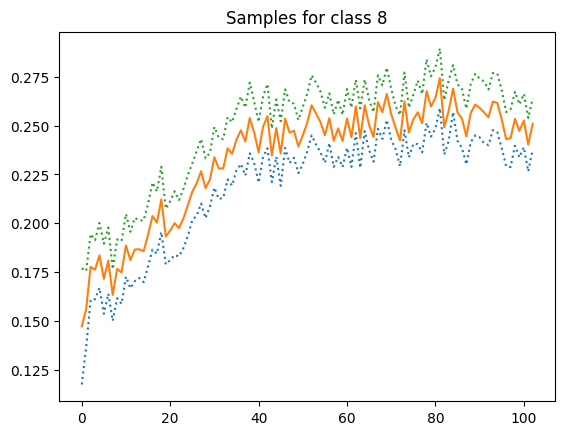

 51%|████████████████████████████████████▏                                  | 51000/100000 [2:31:23<2:28:12,  5.51it/s]

Iter-51000; D_loss: -0.025957372039556503; G_loss: 0.6866135597229004; C_loss: 0.007589113432914019


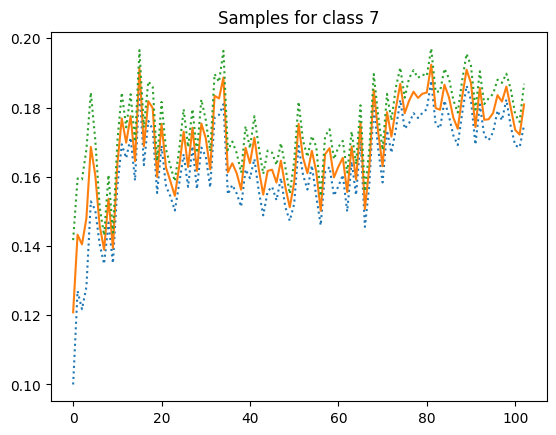

 52%|████████████████████████████████████▉                                  | 52000/100000 [2:34:18<2:32:03,  5.26it/s]

Iter-52000; D_loss: -0.02431020326912403; G_loss: 0.8914052844047546; C_loss: 0.01139608584344387


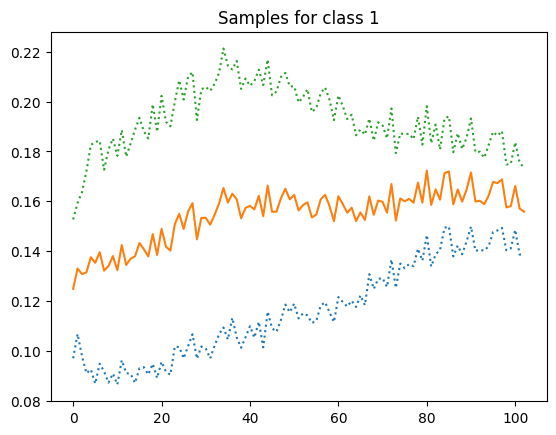

 53%|█████████████████████████████████████▋                                 | 53000/100000 [2:37:07<2:18:11,  5.67it/s]

Iter-53000; D_loss: -0.00794743187725544; G_loss: 0.97605299949646; C_loss: 0.02030451036989689


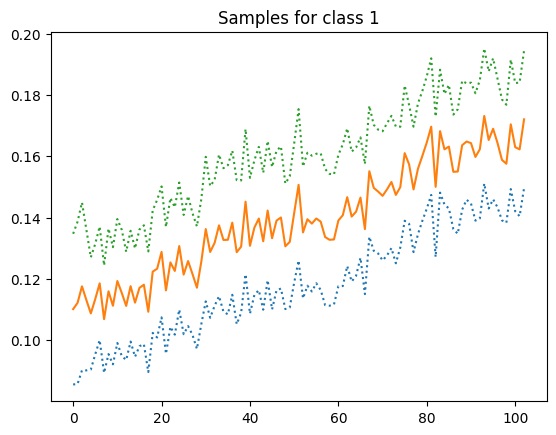

 54%|██████████████████████████████████████▎                                | 54000/100000 [2:39:56<1:50:22,  6.95it/s]

Iter-54000; D_loss: -0.031020453199744225; G_loss: 1.0411975383758545; C_loss: 0.015806613489985466


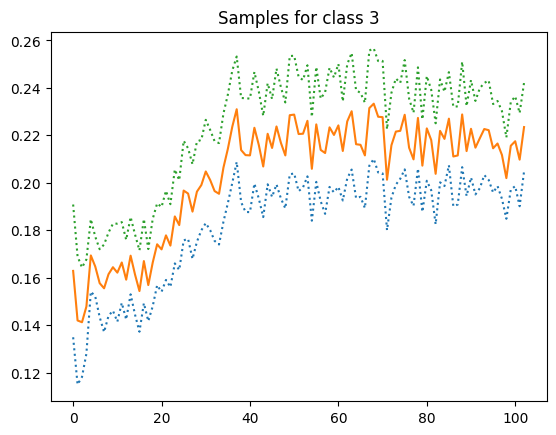

 55%|███████████████████████████████████████                                | 55000/100000 [2:42:46<2:06:57,  5.91it/s]

Iter-55000; D_loss: -0.031071186065673828; G_loss: 1.2095117568969727; C_loss: 0.007453826256096363


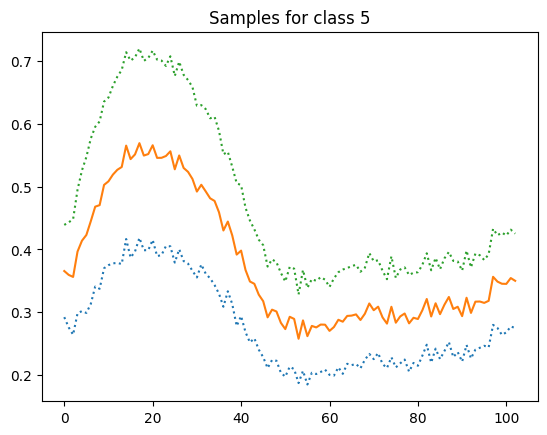

 56%|███████████████████████████████████████▊                               | 56000/100000 [2:45:36<1:55:49,  6.33it/s]

Iter-56000; D_loss: -0.016404684633016586; G_loss: 1.304416537284851; C_loss: 0.021028291434049606


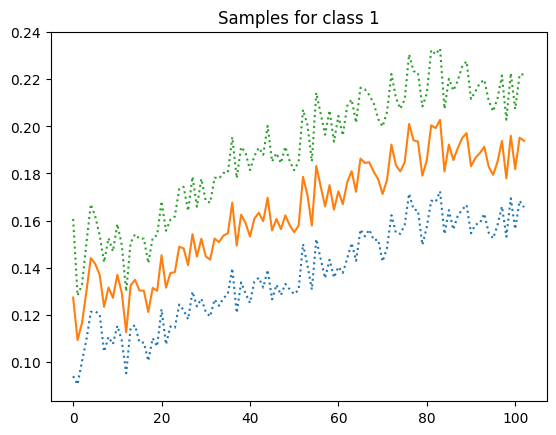

 57%|████████████████████████████████████████▍                              | 57000/100000 [2:48:25<1:57:09,  6.12it/s]

Iter-57000; D_loss: -0.02896326594054699; G_loss: 1.258501410484314; C_loss: 0.008953229524195194


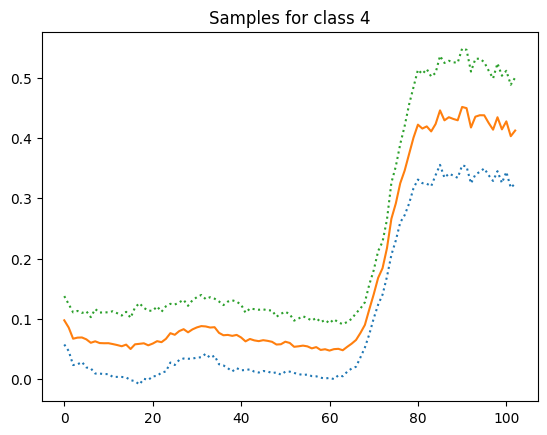

 58%|█████████████████████████████████████████▏                             | 58000/100000 [2:51:16<1:45:18,  6.65it/s]

Iter-58000; D_loss: 0.035886798053979874; G_loss: 1.5326794385910034; C_loss: 0.003540551522746682


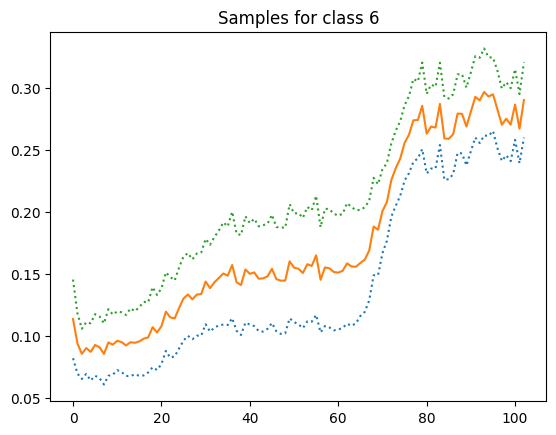

 59%|█████████████████████████████████████████▉                             | 59000/100000 [2:54:06<1:58:32,  5.76it/s]

Iter-59000; D_loss: -0.024363303557038307; G_loss: 1.8073627948760986; C_loss: 0.016580060124397278


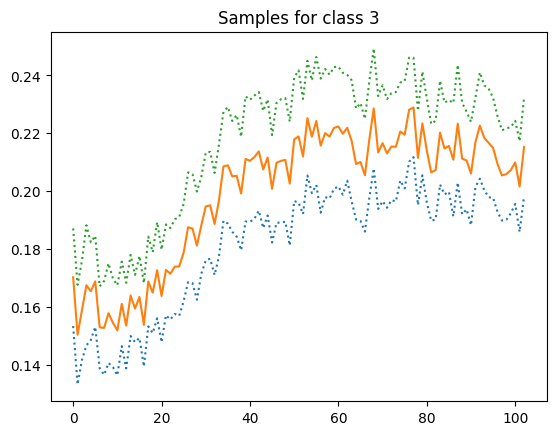

 60%|██████████████████████████████████████████▌                            | 60000/100000 [2:56:54<1:56:24,  5.73it/s]

Iter-60000; D_loss: -0.005010033026337624; G_loss: 1.7900493144989014; C_loss: 0.005183790344744921


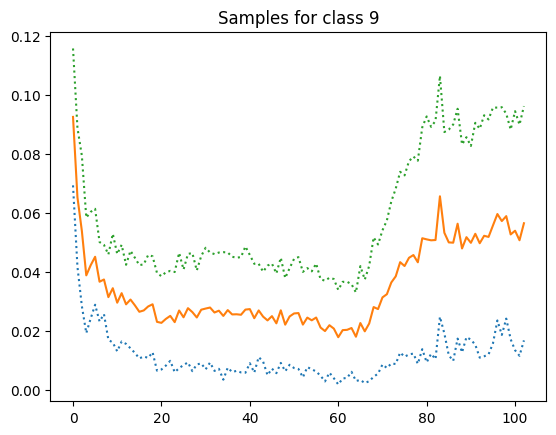

 61%|███████████████████████████████████████████▎                           | 61000/100000 [2:59:45<1:44:29,  6.22it/s]

Iter-61000; D_loss: -0.03509931638836861; G_loss: 1.8572496175765991; C_loss: 0.019371608272194862


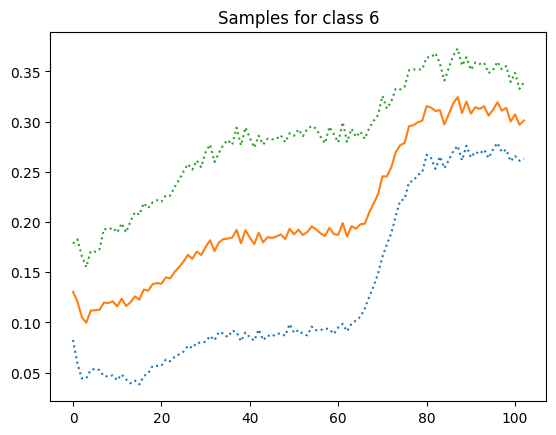

 62%|████████████████████████████████████████████                           | 62000/100000 [3:02:37<1:48:24,  5.84it/s]

Iter-62000; D_loss: -0.03172697499394417; G_loss: 1.841193437576294; C_loss: 0.009509654715657234


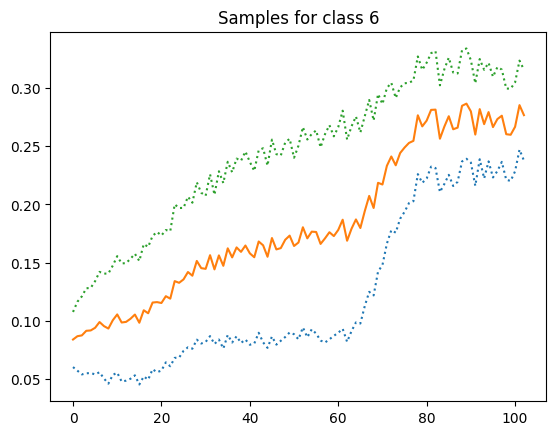

 63%|████████████████████████████████████████████▋                          | 63000/100000 [3:05:31<1:36:19,  6.40it/s]

Iter-63000; D_loss: -0.03139222040772438; G_loss: 1.9478187561035156; C_loss: 0.029679346829652786


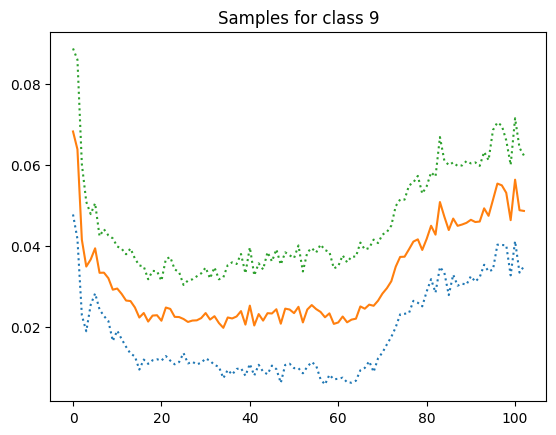

 64%|█████████████████████████████████████████████▍                         | 64000/100000 [3:08:20<1:49:26,  5.48it/s]

Iter-64000; D_loss: -0.036077797412872314; G_loss: 2.159728765487671; C_loss: 0.01555919460952282


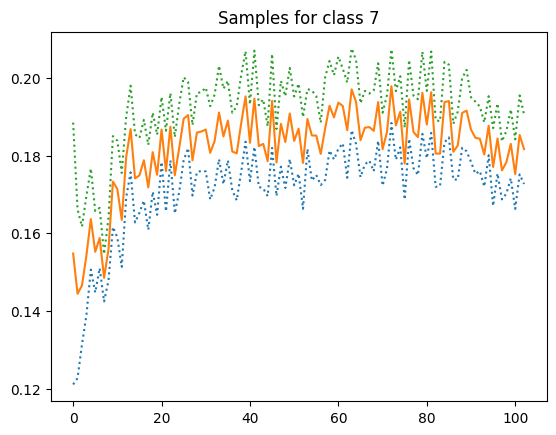

 65%|██████████████████████████████████████████████▏                        | 65000/100000 [3:11:09<1:51:02,  5.25it/s]

Iter-65000; D_loss: -0.023160388693213463; G_loss: 2.201378107070923; C_loss: 0.007286278065294027


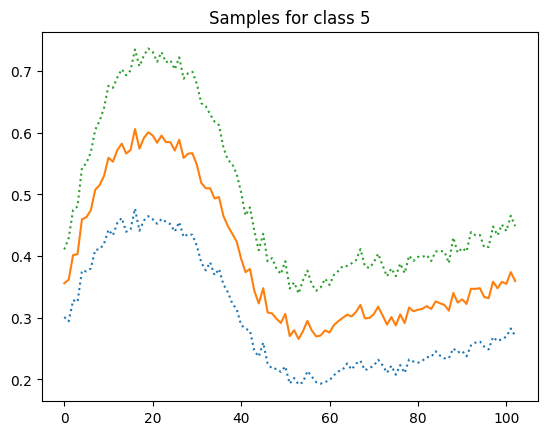

 66%|██████████████████████████████████████████████▊                        | 66000/100000 [3:13:58<1:34:55,  5.97it/s]

Iter-66000; D_loss: -0.03454625606536865; G_loss: 1.9058692455291748; C_loss: 0.006998718250542879


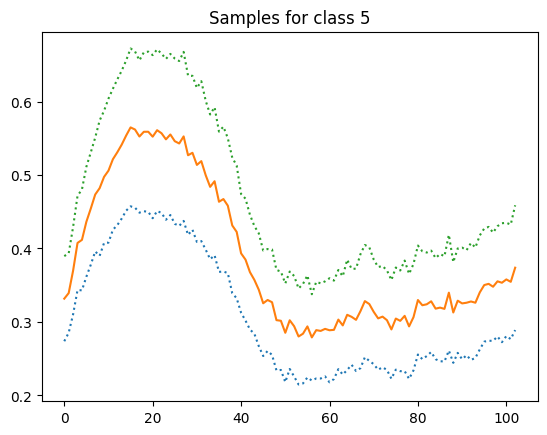

 67%|███████████████████████████████████████████████▌                       | 67000/100000 [3:16:47<1:33:27,  5.89it/s]

Iter-67000; D_loss: -0.046714525669813156; G_loss: 1.8020777702331543; C_loss: 0.005935812834650278


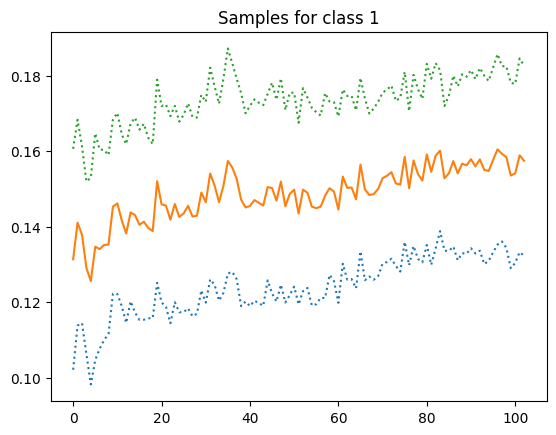

 68%|████████████████████████████████████████████████▎                      | 68000/100000 [3:19:36<1:23:48,  6.36it/s]

Iter-68000; D_loss: -0.02902979403734207; G_loss: 1.7110539674758911; C_loss: 0.00471506966277957


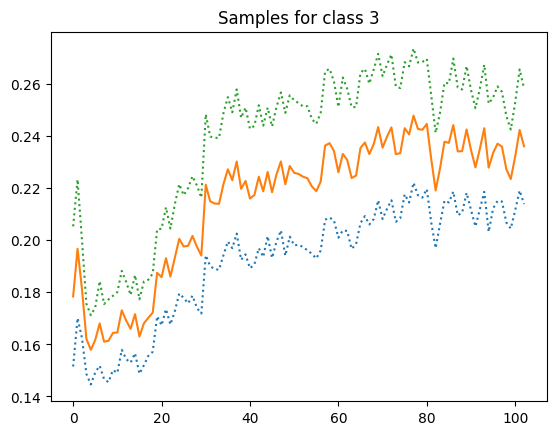

 69%|████████████████████████████████████████████████▉                      | 69000/100000 [3:22:33<1:26:02,  6.01it/s]

Iter-69000; D_loss: -0.01317351683974266; G_loss: 1.2525442838668823; C_loss: 0.03418280556797981


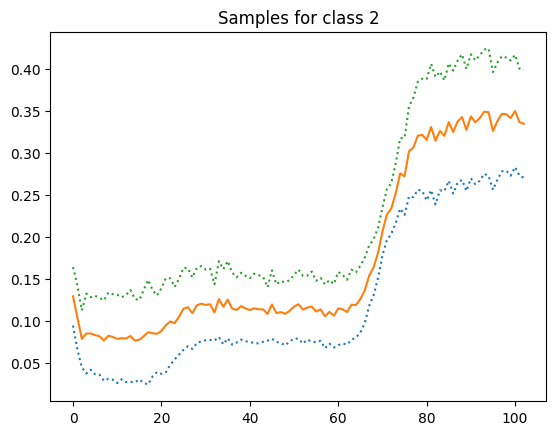

 70%|█████████████████████████████████████████████████▋                     | 70000/100000 [3:25:21<1:17:08,  6.48it/s]

Iter-70000; D_loss: -0.020476069301366806; G_loss: 0.5678008198738098; C_loss: 0.011473030783236027


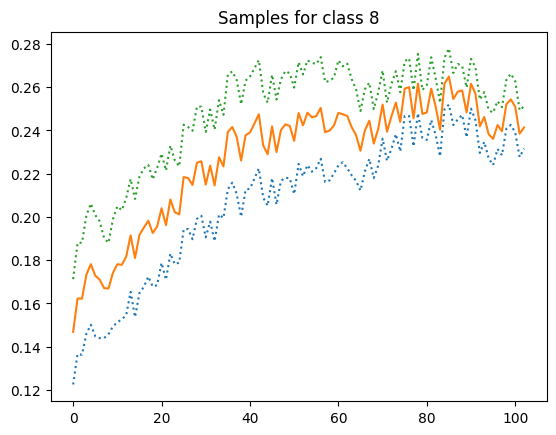

 71%|██████████████████████████████████████████████████▍                    | 71000/100000 [3:28:09<1:28:39,  5.45it/s]

Iter-71000; D_loss: -0.010209217667579651; G_loss: 0.08568064868450165; C_loss: 0.004673538263887167


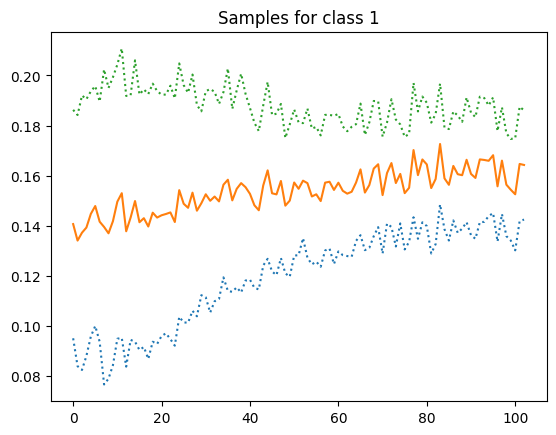

 72%|███████████████████████████████████████████████████                    | 72000/100000 [3:31:01<1:15:39,  6.17it/s]

Iter-72000; D_loss: -0.04158853739500046; G_loss: -0.37452811002731323; C_loss: 0.005902624223381281


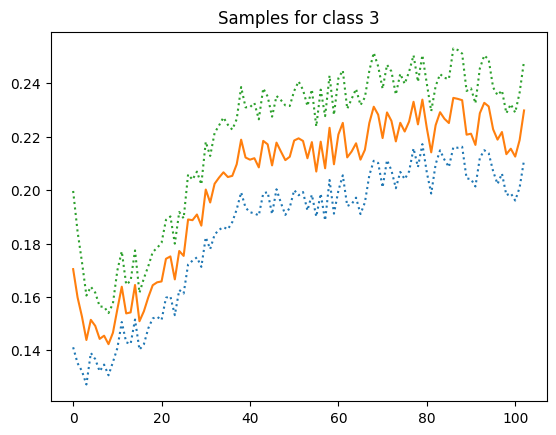

 73%|███████████████████████████████████████████████████▊                   | 73000/100000 [3:33:53<1:12:52,  6.18it/s]

Iter-73000; D_loss: -0.02494531311094761; G_loss: -1.0221542119979858; C_loss: 0.010693814605474472


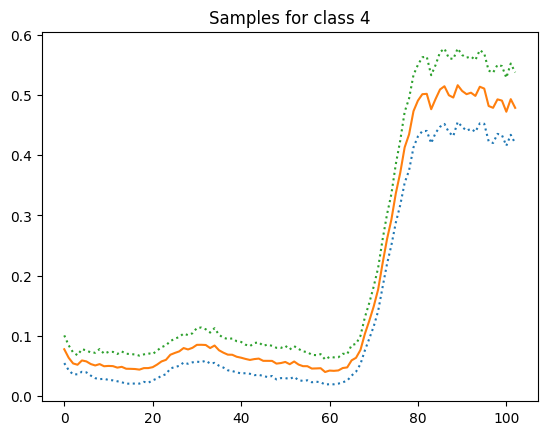

 74%|████████████████████████████████████████████████████▌                  | 74000/100000 [3:36:41<1:12:40,  5.96it/s]

Iter-74000; D_loss: -0.03832458704710007; G_loss: -1.3665281534194946; C_loss: 0.017223646864295006


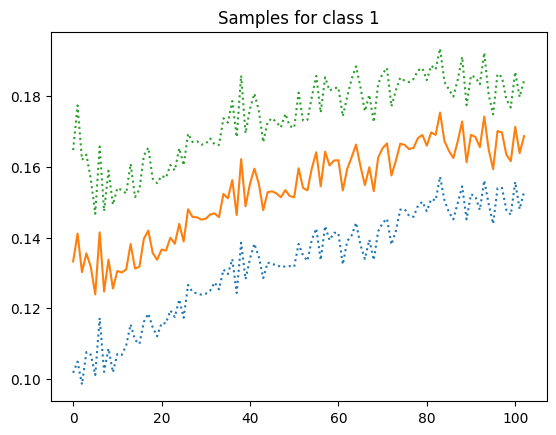

 75%|█████████████████████████████████████████████████████▎                 | 75000/100000 [3:39:30<1:13:53,  5.64it/s]

Iter-75000; D_loss: -0.025617487728595734; G_loss: -2.0214011669158936; C_loss: 0.009851246140897274


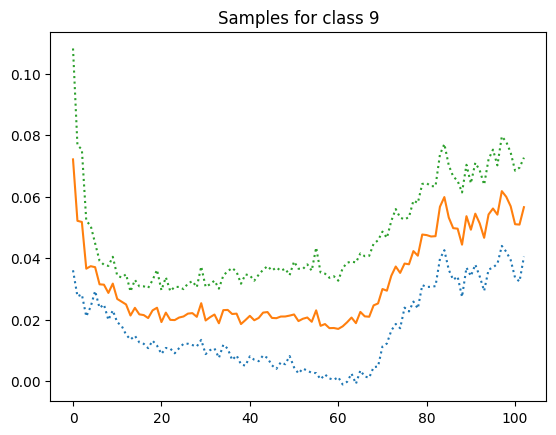

 76%|█████████████████████████████████████████████████████▉                 | 76000/100000 [3:42:22<1:04:32,  6.20it/s]

Iter-76000; D_loss: -0.03130633383989334; G_loss: -2.3900325298309326; C_loss: 0.00793799851089716


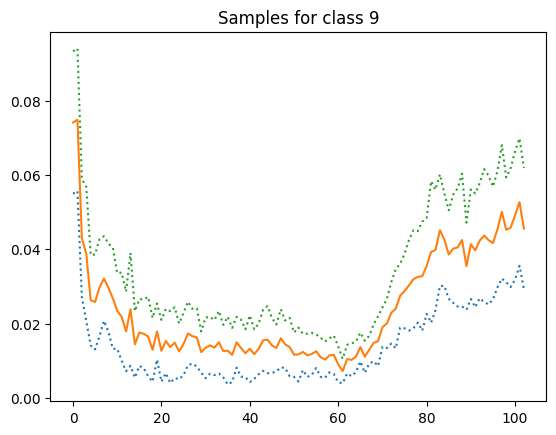

 77%|██████████████████████████████████████████████████████▋                | 77000/100000 [3:45:10<1:06:02,  5.80it/s]

Iter-77000; D_loss: -0.01037647482007742; G_loss: -2.8221709728240967; C_loss: 0.01060346607118845


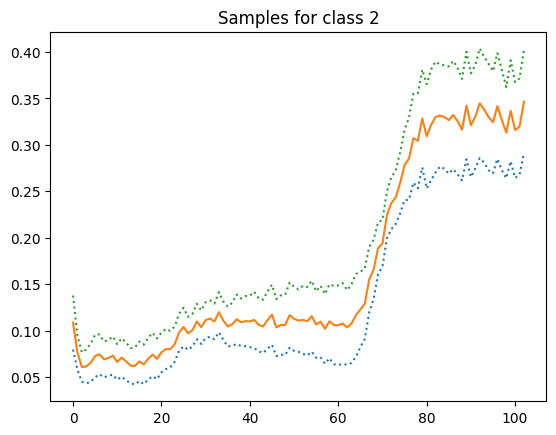

 78%|███████████████████████████████████████████████████████▍               | 78000/100000 [3:48:01<1:08:36,  5.34it/s]

Iter-78000; D_loss: -0.02527724765241146; G_loss: -3.339449167251587; C_loss: 0.006193075329065323


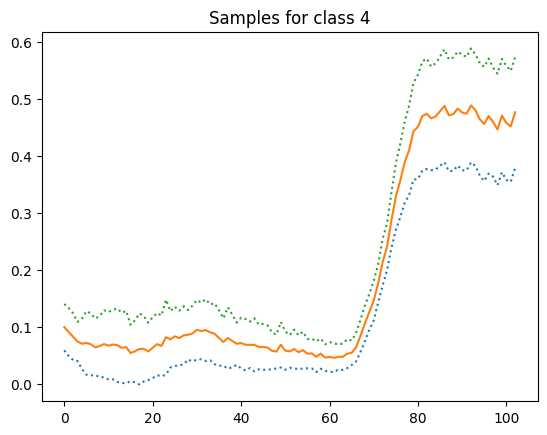

 79%|█████████████████████████████████████████████████████████▋               | 79000/100000 [3:50:51<57:20,  6.10it/s]

Iter-79000; D_loss: -0.03856407850980759; G_loss: -3.882908821105957; C_loss: 0.010992753319442272


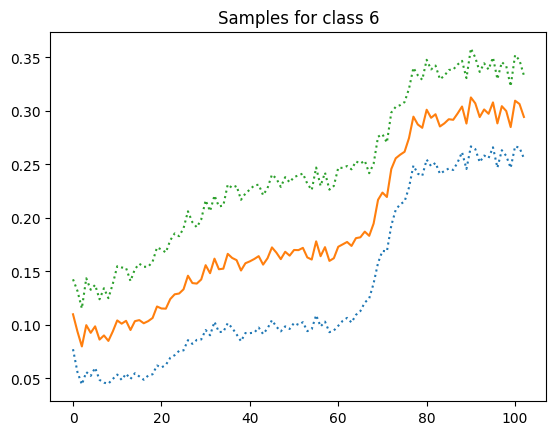

 80%|████████████████████████████████████████████████████████▊              | 80000/100000 [3:53:41<1:02:56,  5.30it/s]

Iter-80000; D_loss: -0.06022634729743004; G_loss: -4.321771621704102; C_loss: 0.012697084806859493


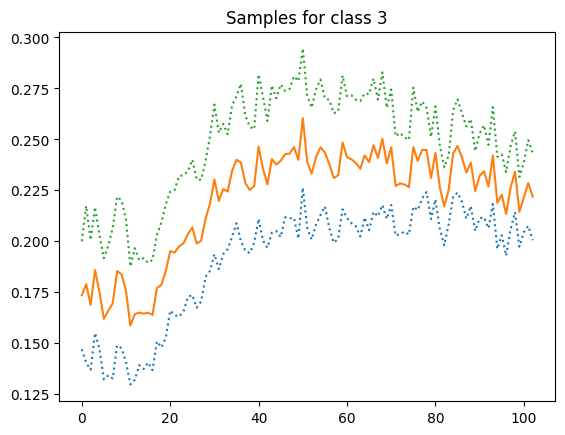

 81%|███████████████████████████████████████████████████████████▏             | 81000/100000 [3:56:30<57:35,  5.50it/s]

Iter-81000; D_loss: -0.025863710790872574; G_loss: -4.835751533508301; C_loss: 0.021828562021255493


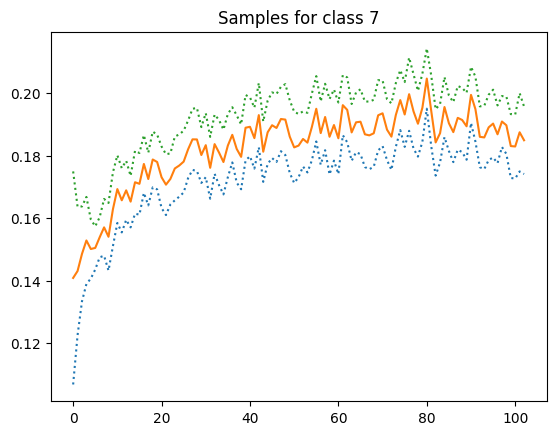

 82%|███████████████████████████████████████████████████████████▊             | 82000/100000 [3:59:20<50:38,  5.92it/s]

Iter-82000; D_loss: -0.0008797561749815941; G_loss: -5.3995161056518555; C_loss: 0.008869284763932228


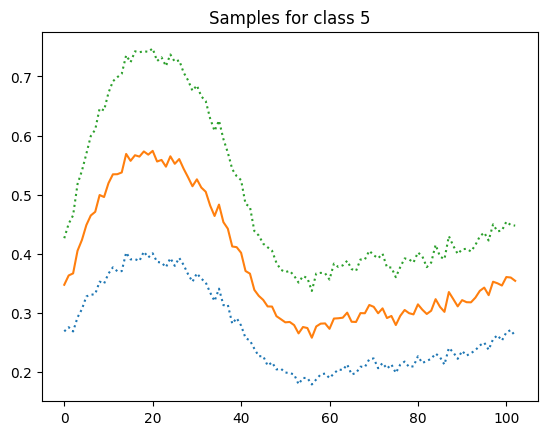

 83%|████████████████████████████████████████████████████████████▌            | 83000/100000 [4:02:13<44:11,  6.41it/s]

Iter-83000; D_loss: -0.007608231157064438; G_loss: -5.921365737915039; C_loss: 0.0041598123498260975


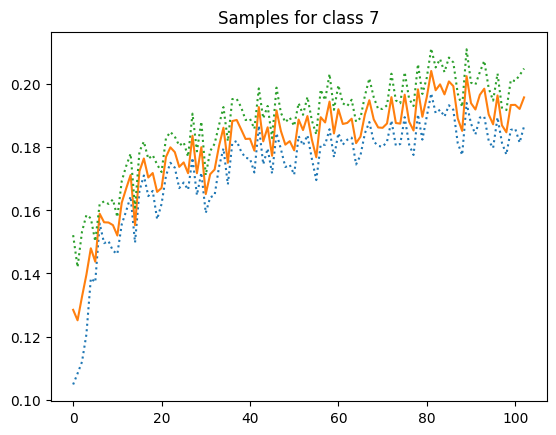

 84%|█████████████████████████████████████████████████████████████▎           | 84000/100000 [4:05:04<44:47,  5.95it/s]

Iter-84000; D_loss: -0.0343472883105278; G_loss: -6.449371814727783; C_loss: 0.009661084040999413


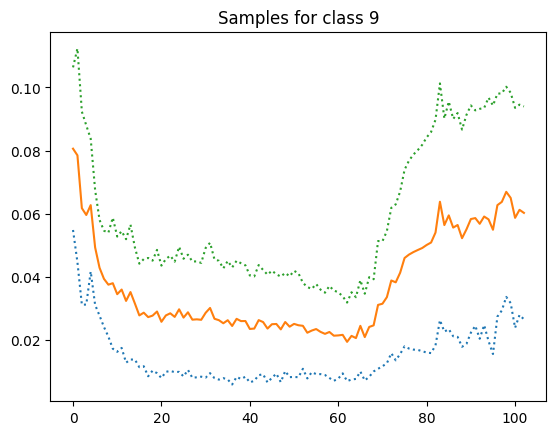

 85%|██████████████████████████████████████████████████████████████           | 85000/100000 [4:07:52<41:23,  6.04it/s]

Iter-85000; D_loss: -0.026972055435180664; G_loss: -6.927229881286621; C_loss: 0.009038344956934452


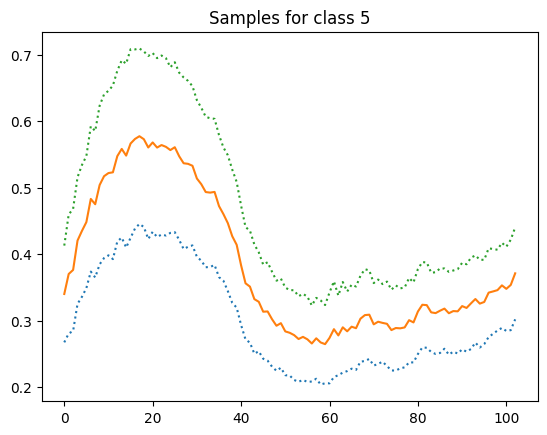

 86%|██████████████████████████████████████████████████████████████▊          | 86000/100000 [4:10:42<35:37,  6.55it/s]

Iter-86000; D_loss: -0.05061709135770798; G_loss: -7.415510654449463; C_loss: 0.008883737027645111


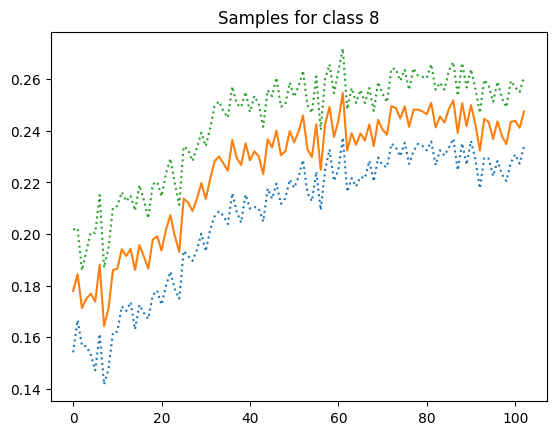

 87%|███████████████████████████████████████████████████████████████▌         | 87000/100000 [4:13:33<38:43,  5.59it/s]

Iter-87000; D_loss: -0.022051794454455376; G_loss: -7.814133644104004; C_loss: 0.03006419539451599


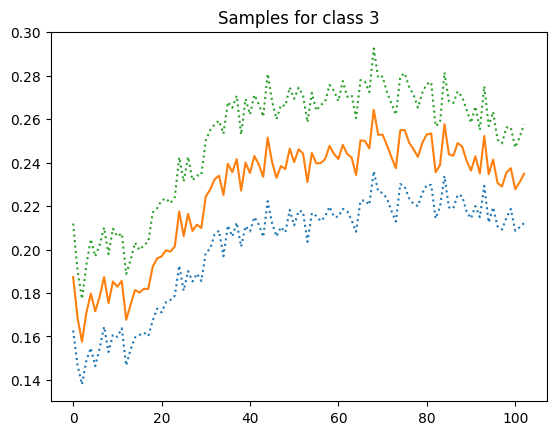

 88%|████████████████████████████████████████████████████████████████▏        | 88000/100000 [4:16:21<30:36,  6.53it/s]

Iter-88000; D_loss: -0.001727905124425888; G_loss: -8.141039848327637; C_loss: 0.004738152492791414


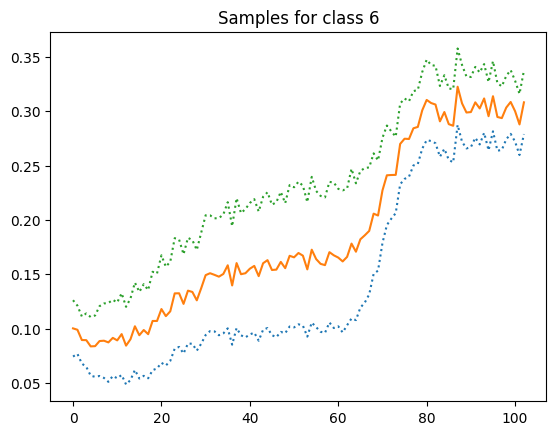

 89%|████████████████████████████████████████████████████████████████▉        | 89000/100000 [4:19:13<32:27,  5.65it/s]

Iter-89000; D_loss: 0.047185830771923065; G_loss: -8.53947639465332; C_loss: 0.008171030320227146


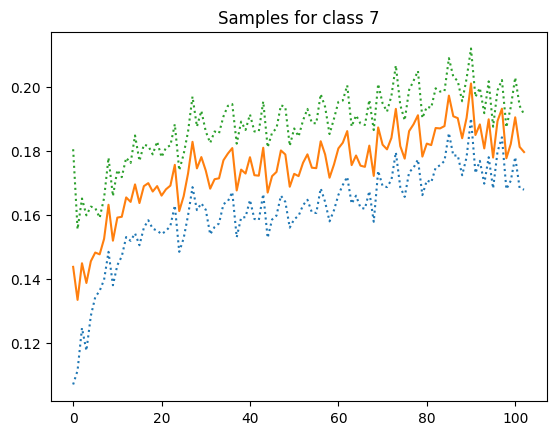

 90%|█████████████████████████████████████████████████████████████████▋       | 90000/100000 [4:22:05<29:13,  5.70it/s]

Iter-90000; D_loss: -0.023193776607513428; G_loss: -8.876825332641602; C_loss: 0.005124492570757866


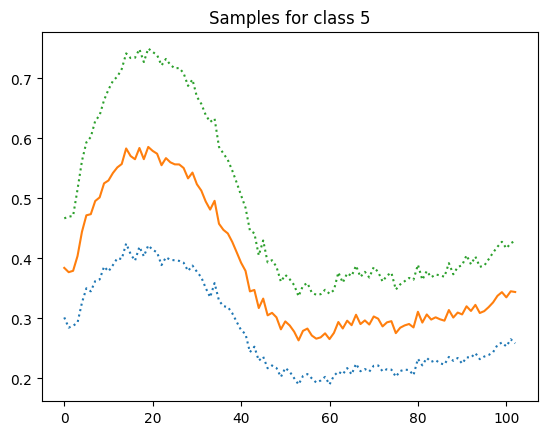

 91%|██████████████████████████████████████████████████████████████████▍      | 91000/100000 [4:24:52<25:53,  5.79it/s]

Iter-91000; D_loss: -0.02080518566071987; G_loss: -9.10871696472168; C_loss: 0.002390837762504816


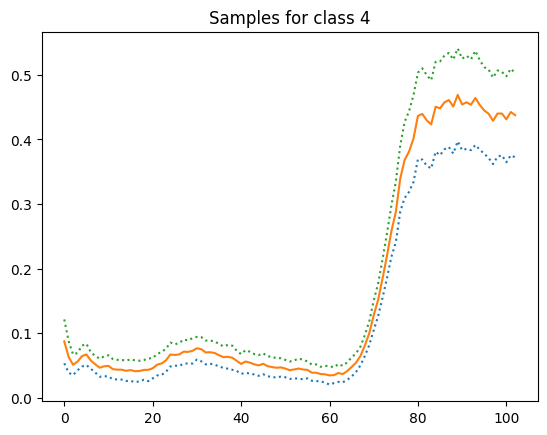

 92%|███████████████████████████████████████████████████████████████████▏     | 92000/100000 [4:27:44<18:44,  7.12it/s]

Iter-92000; D_loss: -0.029787827283143997; G_loss: -9.506303787231445; C_loss: 0.0038950457237660885


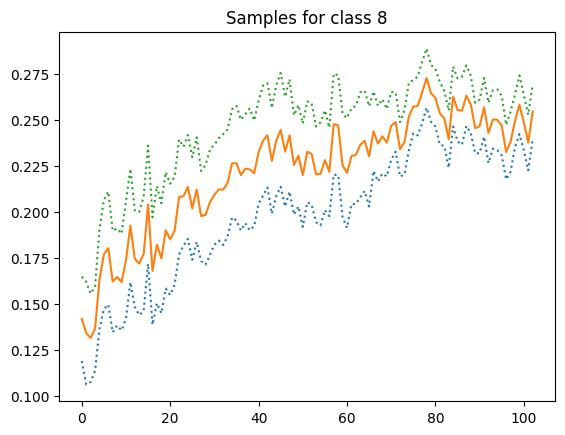

 93%|███████████████████████████████████████████████████████████████████▉     | 93000/100000 [4:30:35<25:01,  4.66it/s]

Iter-93000; D_loss: -0.01183394342660904; G_loss: -9.732038497924805; C_loss: 0.0078115928918123245


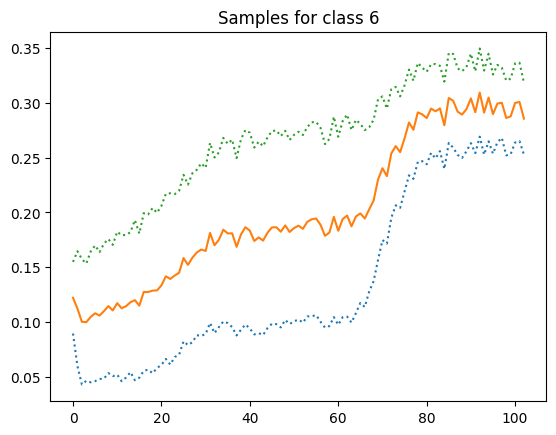

 94%|████████████████████████████████████████████████████████████████████▌    | 94000/100000 [4:33:26<13:59,  7.15it/s]

Iter-94000; D_loss: -0.01803307607769966; G_loss: -10.075439453125; C_loss: 0.003525109961628914


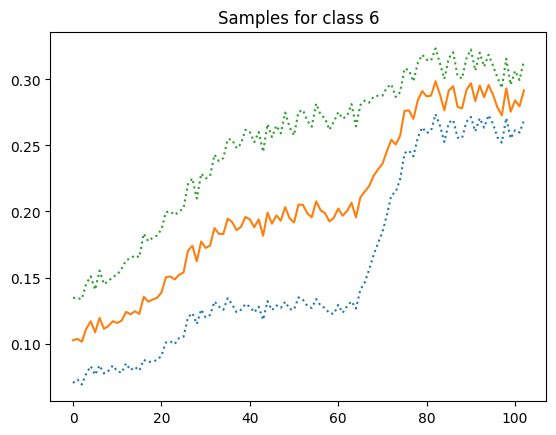

 95%|█████████████████████████████████████████████████████████████████████▎   | 95000/100000 [4:36:14<15:17,  5.45it/s]

Iter-95000; D_loss: -0.03601464256644249; G_loss: -10.317154884338379; C_loss: 0.021993275731801987


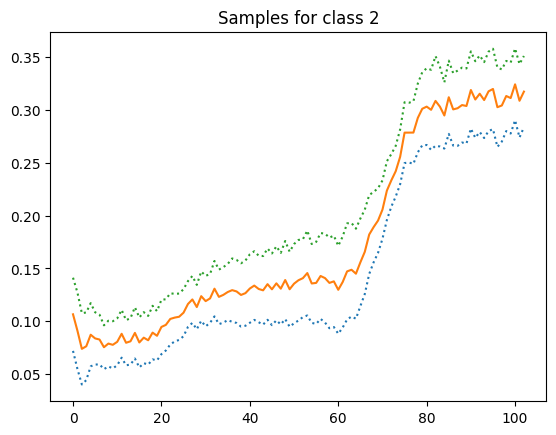

 96%|██████████████████████████████████████████████████████████████████████   | 96000/100000 [4:39:06<10:36,  6.28it/s]

Iter-96000; D_loss: -0.02777300588786602; G_loss: -10.460844039916992; C_loss: 0.3011050522327423


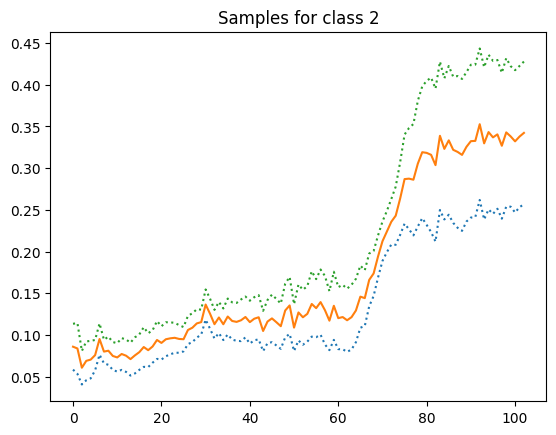

 97%|██████████████████████████████████████████████████████████████████████▊  | 97000/100000 [4:41:58<07:00,  7.13it/s]

Iter-97000; D_loss: -0.024039868265390396; G_loss: -10.667098999023438; C_loss: 0.010694296099245548


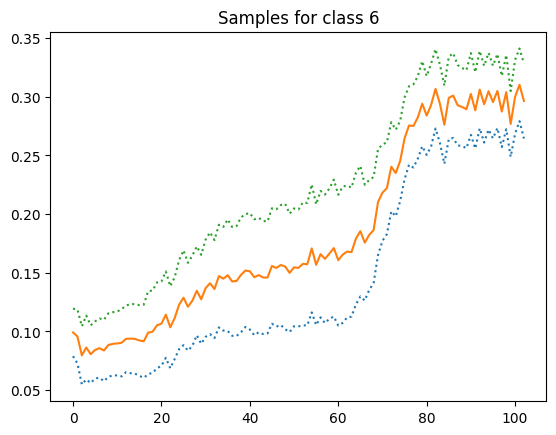

 98%|███████████████████████████████████████████████████████████████████████▌ | 98000/100000 [4:44:48<06:19,  5.27it/s]

Iter-98000; D_loss: -0.03873422369360924; G_loss: -10.80251407623291; C_loss: 0.004697582684457302


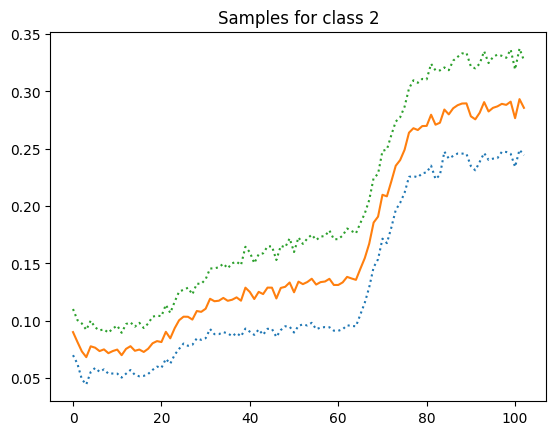

 99%|████████████████████████████████████████████████████████████████████████▎| 99000/100000 [4:47:39<02:44,  6.07it/s]

Iter-99000; D_loss: -0.025575751438736916; G_loss: -10.98808765411377; C_loss: 0.0035844300873577595


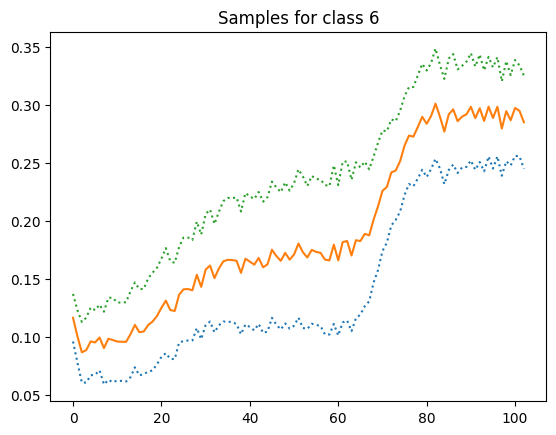

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [4:50:29<00:00,  5.74it/s]


In [8]:
import torch.optim as optim
# Get networks
G = Generator().cuda()
D = Discriminator().cuda()
C = Classifier().cuda()
# Use RMSProp optimizer
G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)
C_solver = optim.RMSprop(C.parameters(), lr=lr)

for it in tqdm(range(100000)):
    ###########################
    # (1) Update C and D      #
    ###########################
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update
    for p in C.parameters():
        p.requires_grad = True
    
    # D is trained d_step times for each iteration
    for _, (X, y), (X_, y_) in zip(range(d_step), data_loader, data_loader):
        D.zero_grad()

        # Sample random noise
        z = torch.randn(y.size(0), z_dim).squeeze()
        X, y = X.float(), y.float()
        X_, y_ = X_.float(), y_.float()
        # Mixup
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        X = lam*X + (1. - lam)*X_
        X, y, z = X.cuda(), y.cuda(), z.cuda()
        y_ = y_.cuda()
        
        # Get discriminator prediction on real samples
        D_real = D(X).mean()
        # Get discriminator prediction on fake samples
        fake_samples = G(z, y)
        D_fake = D(fake_samples).mean()
        # Compute gradient penalty
        gradient_penalty = calc_gradient_penalty(D, X.data, fake_samples.data)
        # Compute loss and backpropagate
        D_loss = D_fake - D_real + gradient_penalty
        flip = np.random.random() < flip_percentage
        if flip: 
            # Flip real and fake
            gradient_penalty = calc_gradient_penalty(D, fake_samples.data, X.data)
            D_loss = D_real - D_fake + gradient_penalty
        D_loss.backward()
        D_solver.step()
    
        ######################
        #  Update C network  #
        ######################
        C.zero_grad()
        # Get class values
        _, classes = torch.max(y, dim=1)
        _, classes_ = torch.max(y_, dim=1)
        # Get predictions from C
        if flip:
            fake_samples = G(z, y)
            pred = C(fake_samples)
            # Compute loss and backpropagate
            C_loss = F.cross_entropy(pred, classes, weight=class_weights)
        else:
            pred = F.log_softmax(C(X))
            C_loss = lam * F.nll_loss(pred, classes) + (1. - lam) * F.nll_loss(pred, classes_)
        C_loss.backward()
        C_solver.step()


    ############################
    # (2) Update G network
    ###########################
    for p in D.parameters():
        p.requires_grad = False  # to avoid computation
    for p in C.parameters():
        p.requires_grad = False
    reset_grad(C, G, D)

    # Sample random noise
    z = torch.randn(y.size(0), z_dim).squeeze()
    z = z.cuda()
    # Generate fake samples
    G_sample = G(z, y)
    D_fake = D(G_sample)
    pred = C(G_sample)
    C_loss = F.cross_entropy(pred, classes, weight=class_weights)
    # Fool the discriminator (WGAN)
    G_loss = -torch.mean(D_fake)
    # Include the auxialiary classifier loss (AC-GAN)
    loss = G_loss + c_weight * C_loss
    # Backpropagate
    loss.backward()
    G_solver.step()

    # Print and plot every now and then
    if it % 1000 == 0:
        with torch.no_grad():
            print('Iter-{}; D_loss: {}; G_loss: {}; C_loss: {}'.format(it,
                                                           D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy(),
                                                           C_loss.data.cpu().numpy()))
            z = torch.randn(mb_size, z_dim).squeeze().cuda()
            c = np.zeros(shape=[mb_size, c_dim], dtype='float32')
            idx = np.random.randint(1, data_loader.dataset.n_classes)
            c[:, idx] = 1.
            c = torch.from_numpy(c).squeeze().cuda()
            samples = G(z, c).data.cpu().numpy()[:16]
            pred = G(z, c)
            plot_mean_std(samples)
            plt.title("Samples for class {}".format(idx))
            plt.show()


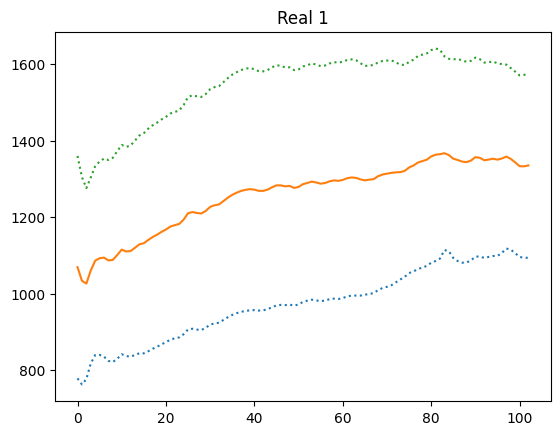

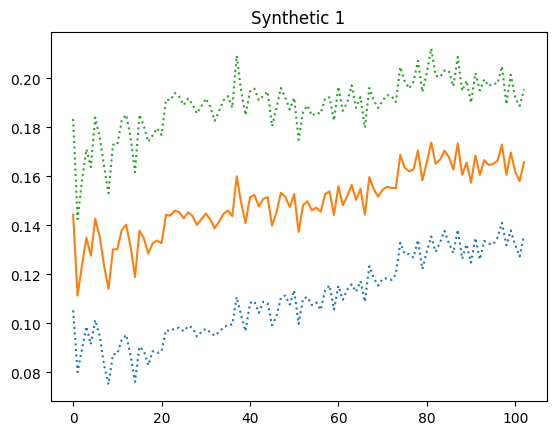

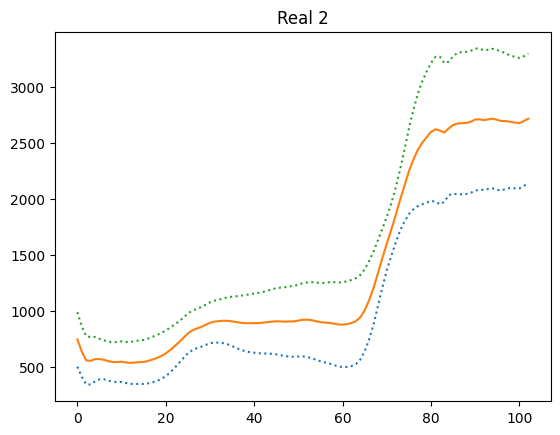

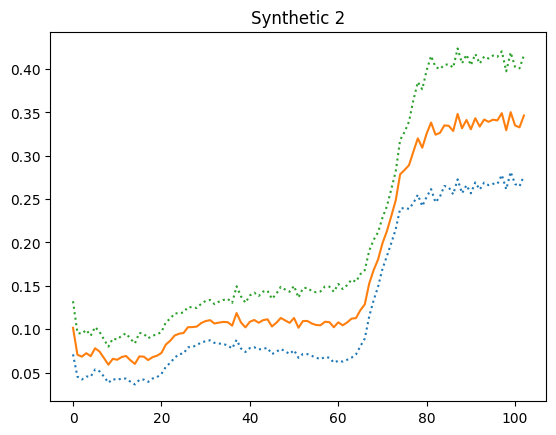

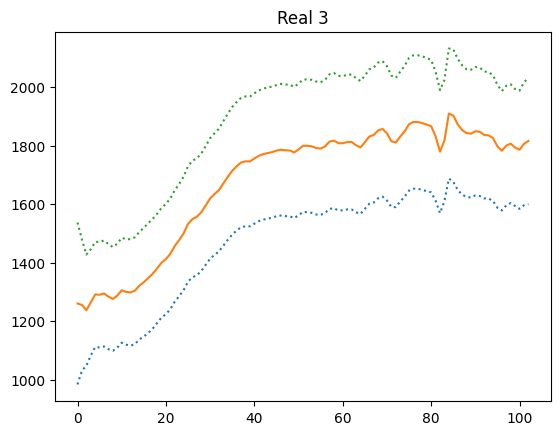

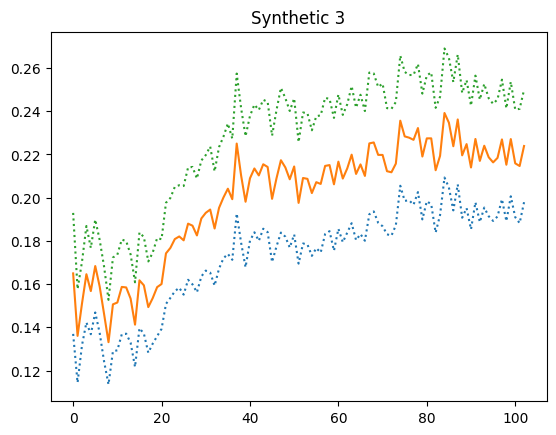

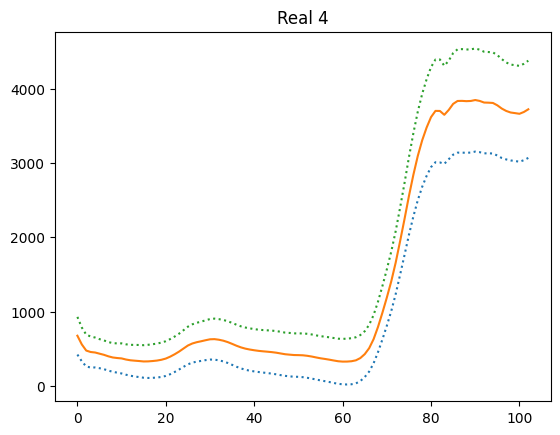

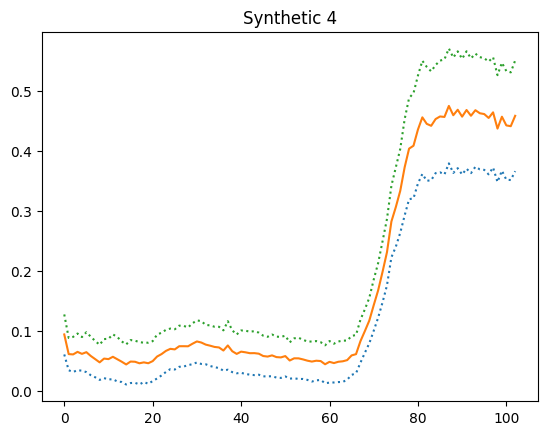

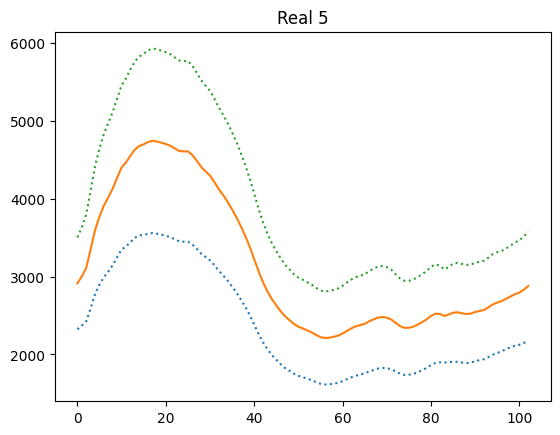

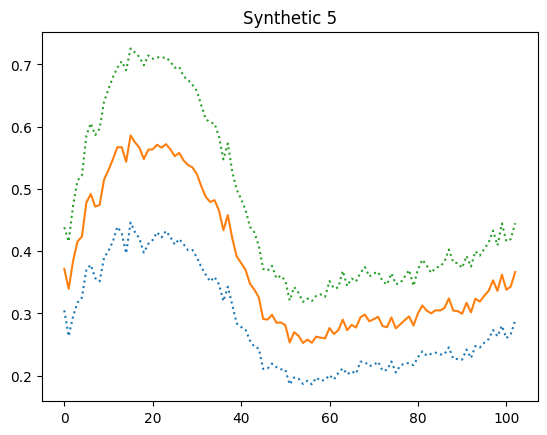

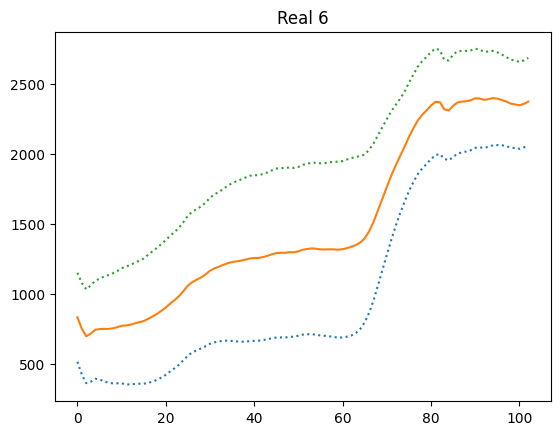

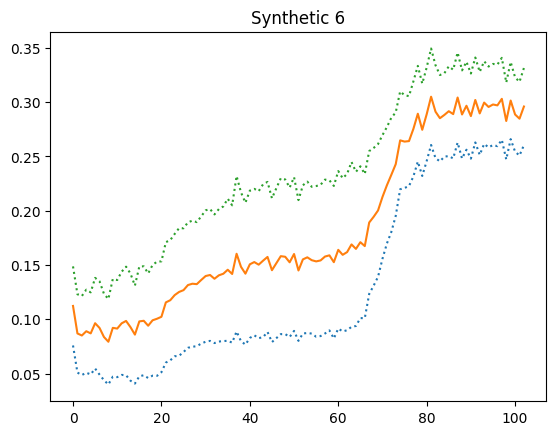

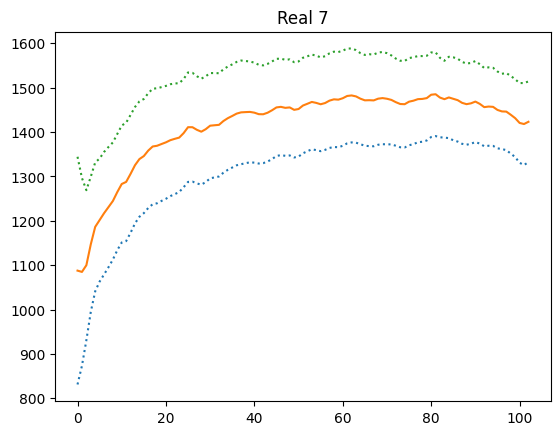

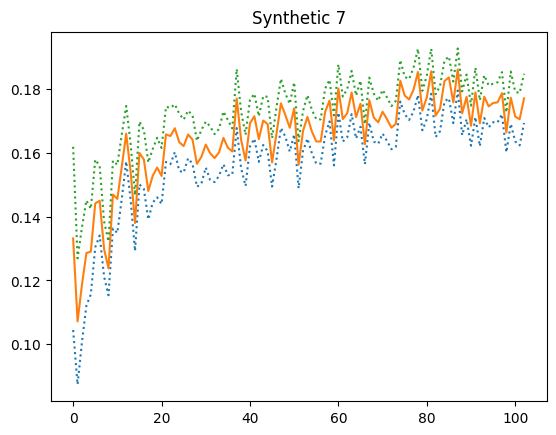

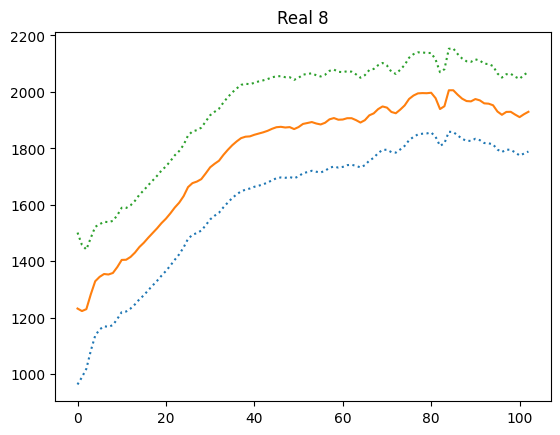

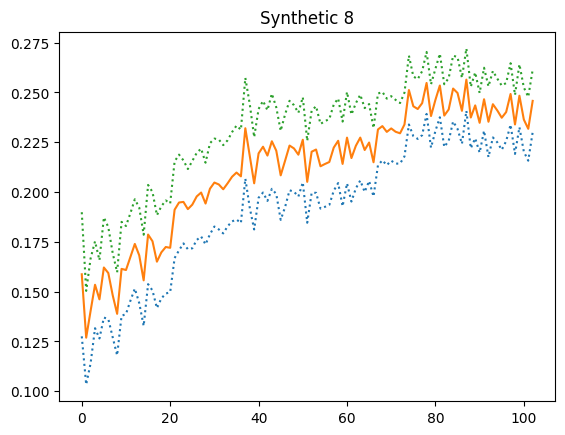

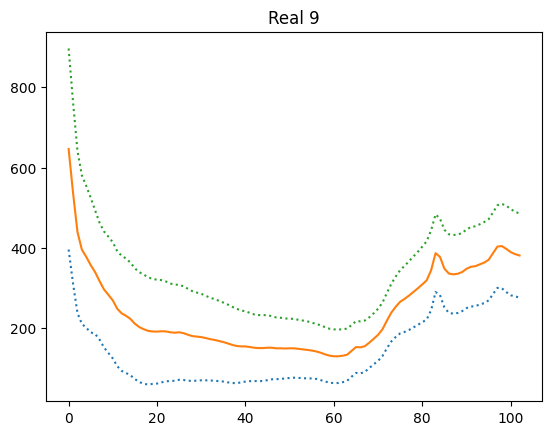

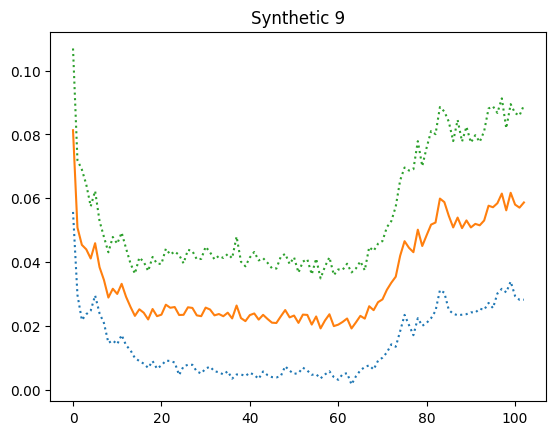

In [9]:
for c in np.unique(gt):
    # 0 is the "undefined" class
    if c == 0:
        continue
    
    # Get the mean spectrum +- std for this class
    spectras = img[gt == c, :]
    plot_mean_std(spectras)
    plt.title("Real {}".format(c))
    plt.show()
    
    # Get as many fake spectras as real ones
    synthetic_spectras = []
    with torch.no_grad():
        while len(synthetic_spectras) < len(spectras):
            z = torch.randn(mb_size, z_dim).cuda()
            y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[c]).float()
            y = y.unsqueeze(0).repeat(mb_size, 1).cuda()
            G_sample = G(z, y)
            _, classes = torch.max(y, 1)
            _, pred = torch.max(C(G_sample), 1)
            synthetic_spectras += list(G_sample.cpu().data.numpy())
    plt.show()
    plot_mean_std(synthetic_spectras)
    plt.title("Synthetic {}".format(c))
    plt.show()

In [10]:
import sklearn.svm
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.mixture

In [11]:
img = (img - img.min()) / (img.max() - img.min())
X_train = np.array([img[x,y] for x,y in zip(*np.nonzero(train_gt))])
y_train = np.array([gt[x,y] for x,y in zip(*np.nonzero(train_gt))])
X_test = np.array([img[x,y] for x,y in zip(*np.nonzero(test_gt))])
y_test = np.array([test_gt[x,y] for x,y in zip(*np.nonzero(test_gt))])

In [12]:
gmms = [sklearn.mixture.GaussianMixture(n_components=20) for _ in range(c_dim)]
for y in np.unique(y_train):
    gmms[y].fit(X_train[y_train == y])

In [13]:
def gmm_create_fake_dataset(gmms, y):
    fake_X = []
    y_fake = []
    for y in np.unique(y):
        n_samples = np.count_nonzero(y_test == y)
        samples = gmms[y].sample(n_samples)[0]
        fake_X.append(samples)
        y_fake += [y] * n_samples
    fake_X = np.concatenate(fake_X)
    y_fake = np.array(y_fake)
    return fake_X, y_fake

#fake_X_train, fake_y_train = gmm_create_fake_dataset(gmms, y_train)
#fake_X_test, fake_y_test = gmm_create_fake_dataset(gmms, y_test)

In [14]:
scaler = sklearn.preprocessing.StandardScaler()
svm = sklearn.svm.SVC()
#estimator = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm)])
estimator = sklearn.pipeline.Pipeline(steps=[('svm', svm)])
#tuned_parameters = {'svm__C': [0.1, 1, 10, 100, 1000], 'svm__kernel': ['linear']}
tuned_parameters = {'svm__C': [1000], 'svm__kernel': ['linear']}
clf = sklearn.model_selection.GridSearchCV(estimator, tuned_parameters, cv=5, n_jobs=4)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
best_params = clf.best_params_
print("The best SVM was obtained using {} and performed at {:.2f} accuracy.".format(best_params, 100 * score))

The best SVM was obtained using {'svm__C': 1000, 'svm__kernel': 'linear'} and performed at 90.16 accuracy.


In [15]:
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      0.94      0.90      6302
           2       0.92      0.97      0.95     17756
           3       0.79      0.78      0.79      1977
           4       0.94      0.89      0.91      2906
           5       0.97      0.99      0.98      1273
           6       0.89      0.77      0.82      4819
           7       0.84      0.54      0.65      1271
           8       0.86      0.83      0.84      3502
           9       1.00      1.00      1.00       900

    accuracy                           0.90     40706
   macro avg       0.90      0.86      0.87     40706
weighted avg       0.90      0.90      0.90     40706



In [16]:
def gan_create_fake_dataset(labels):
    with torch.no_grad():
        spectras = []
        for l in np.array_split(labels, len(labels) // mb_size):
            z = torch.randn(len(l), z_dim).cuda()
            y = np.zeros((len(l), data_loader.dataset.n_classes))
            for i, label in enumerate(l):
                y[i] = np.eye(data_loader.dataset.n_classes)[label]
            y = torch.from_numpy(y).float()
            eps = torch.randn(y.size())/10
            #y += eps
            y = y.cuda()
            G_sample = G(z, y)
            spectras += list(G_sample.cpu().data.numpy())
        return np.array(spectras), np.array(labels)

In [17]:
fake_X_train, fake_y_train = gan_create_fake_dataset(y_train)
fake_X_test, fake_y_test = gan_create_fake_dataset(y_test)

In [18]:
clf.score(fake_X_test, fake_y_test)

0.9711344764899523

In [19]:
y_fake_pred = clf.predict(fake_X_test)
from sklearn.metrics import classification_report
print(classification_report(fake_y_test, y_fake_pred))

              precision    recall  f1-score   support

           1       0.99      0.97      0.98      6302
           2       0.97      1.00      0.98     17756
           3       1.00      0.99      0.99      1977
           4       1.00      0.88      0.93      2906
           5       0.96      1.00      0.98      1273
           6       0.92      0.96      0.94      4819
           7       1.00      0.98      0.99      1271
           8       0.95      0.91      0.93      3502
           9       1.00      0.95      0.98       900

    accuracy                           0.97     40706
   macro avg       0.98      0.96      0.97     40706
weighted avg       0.97      0.97      0.97     40706



In [20]:
svm_fake = sklearn.svm.SVC()
clf_fake = sklearn.pipeline.Pipeline(steps=[('svm', svm_fake)])
clf_fake.set_params(**clf.best_params_)
clf_fake.fit(np.concatenate([fake_X_train]), np.concatenate([fake_y_train]))

Pipeline(steps=[('svm', SVC(C=1000, kernel='linear'))])

In [21]:
clf_fake.score(fake_X_test, fake_y_test)

0.9973713948803616

In [22]:
clf_fake.score(X_test, y_test)

0.8634353657937405

In [23]:
svm_augmented = sklearn.svm.SVC()
#clf_augmented = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm_augmented)])
clf_augmented = sklearn.pipeline.Pipeline(steps=[('svm', svm_augmented)])
clf_augmented.set_params(**clf.best_params_)
clf_augmented.fit(np.concatenate([X_train, fake_X_train]), np.concatenate([y_train, fake_y_train]))

Pipeline(steps=[('svm', SVC(C=1000, kernel='linear'))])

In [24]:
clf_augmented.score(X_test, y_test)

0.9018080872598634

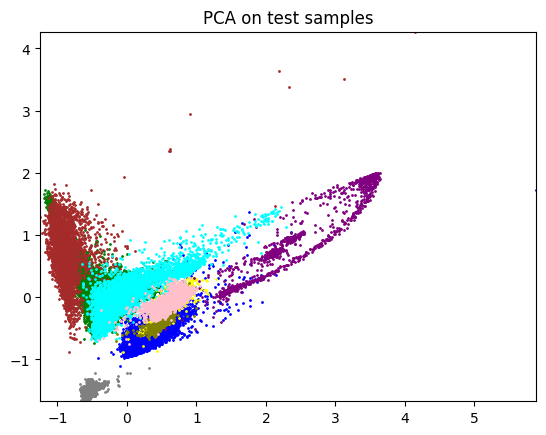

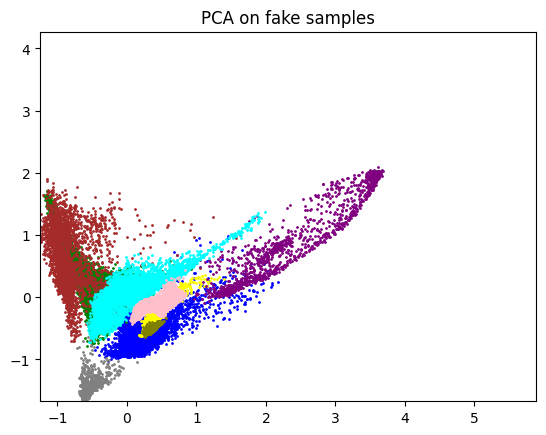

In [25]:
%matplotlib inline
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
x_min, x_max = np.min(X_pca[:,0]), np.max(X_pca[:,0])
y_min, y_max = np.min(X_pca[:,1]), np.max(X_pca[:,1])

colors = ['red', 'blue', 'green', 'yellow', 'brown', 'purple', 'cyan', 'olive', 'pink', 'gray']
for i, color in enumerate(colors):
    idx = y_test == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, s=1)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on test samples')
plt.show()

X_fake_pca = pca.transform(fake_X_test)
for i, color in enumerate(colors):
    idx = fake_y_test == i
    plt.scatter(X_fake_pca[idx, 0], X_fake_pca[idx, 1], s=1, c=color)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on fake samples')
plt.show()

In [26]:
def train(net, X_train, y_train, epochs=100):
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(),
                                             torch.from_numpy(y_train).long())
    loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)
    solver = optim.Adam(net.parameters(), amsgrad=True)
    net.train()
    it = 0
    losses = []
    for _ in tqdm(range(epochs)):
        for X, y in loader:
            it += 1
            net.zero_grad()
            X, y = X.cuda(), y.cuda()
            out = net(X)
            loss = F.cross_entropy(out, y)
            loss.backward()
            solver.step()
            losses.append(loss.item())
            if it % 10000 == 0:
                print("Loss at {} = {}".format(it, loss.item()))
                plt.plot(losses) and plt.show()
    return net

 33%|█████████████████████████▋                                                   | 3331/10000 [02:20<04:39, 23.85it/s]

Loss at 10000 = 0.35664910078048706


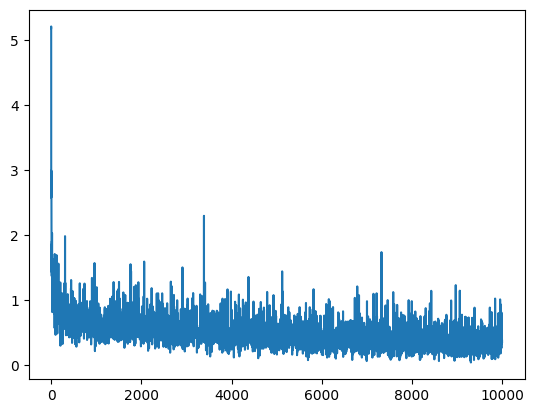

 67%|███████████████████████████████████████████████████▎                         | 6664/10000 [04:43<02:37, 21.11it/s]

Loss at 20000 = 0.17993681132793427


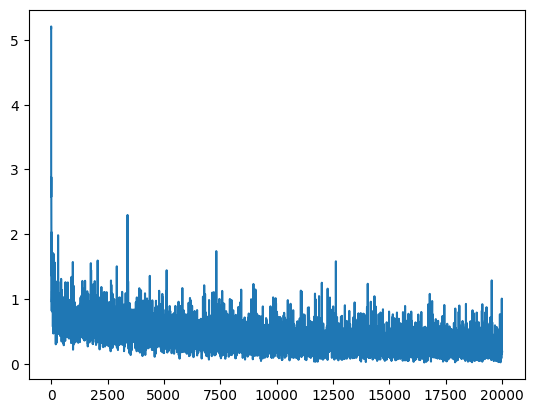

100%|████████████████████████████████████████████████████████████████████████████▉| 9998/10000 [07:06<00:00, 24.61it/s]

Loss at 30000 = 0.19070111215114594


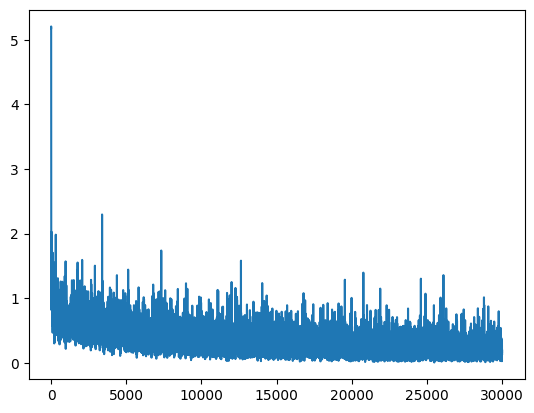

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:06<00:00, 23.43it/s]


In [27]:
C_real = train(Classifier().cuda(), X_train, y_train, epochs=15000)

In [28]:
def test(net, X_test, y_test):
    with torch.no_grad():
        net.eval()
        print(X_test.shape)
        print(y_test.shape)
        dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(),
                                                 torch.from_numpy(y_test).long())
        loader = torch.utils.data.DataLoader(dataset, batch_size=mb_size)
        pred = []
        for X, y in loader:
            X, y = X.cuda(), y.cuda()
            out = net(X)
            _, out = torch.max(out, 1)
            pred.append(out.cpu().numpy())
        pred = np.concatenate(pred)
        print(classification_report(y_test, pred, digits=4))
    return pred

In [29]:
test(C_real, X_test, y_test)

(40706, 103)
(40706,)
              precision    recall  f1-score   support

           1     0.9577    0.9305    0.9439      6302
           2     0.9404    0.9913    0.9652     17756
           3     0.7379    0.8872    0.8057      1977
           4     0.9712    0.8827    0.9248      2906
           5     0.9891    0.9984    0.9937      1273
           6     0.9600    0.8377    0.8947      4819
           7     0.8549    0.8993    0.8765      1271
           8     0.8977    0.8015    0.8469      3502
           9     0.9989    0.9933    0.9961       900

    accuracy                         0.9320     40706
   macro avg     0.9231    0.9135    0.9164     40706
weighted avg     0.9343    0.9320    0.9315     40706



array([3, 8, 1, ..., 2, 2, 2], dtype=int64)

 20%|███████████████▍                                                             | 1998/10000 [02:33<12:35, 10.59it/s]

Loss at 10000 = 0.03740285336971283


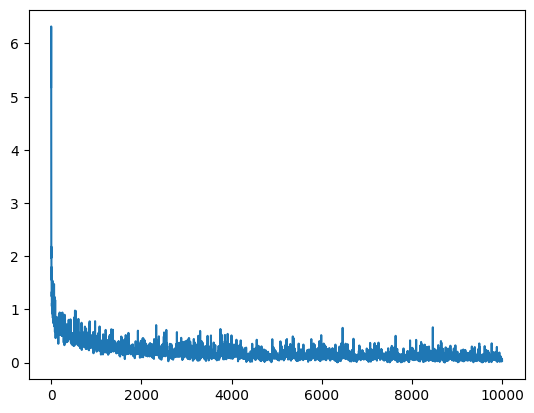

 40%|██████████████████████████████▊                                              | 3999/10000 [05:13<07:32, 13.25it/s]

Loss at 20000 = 0.056279052048921585


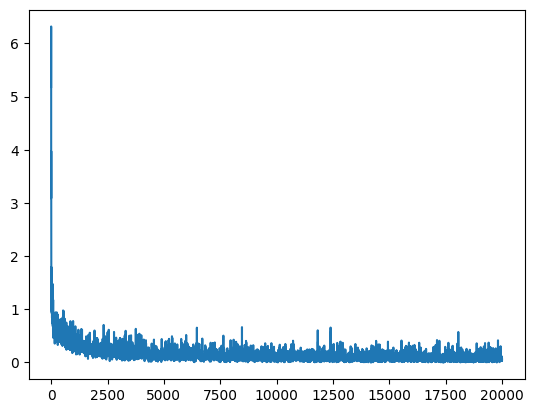

 60%|██████████████████████████████████████████████▏                              | 5999/10000 [08:05<05:52, 11.36it/s]

Loss at 30000 = 0.041787583380937576


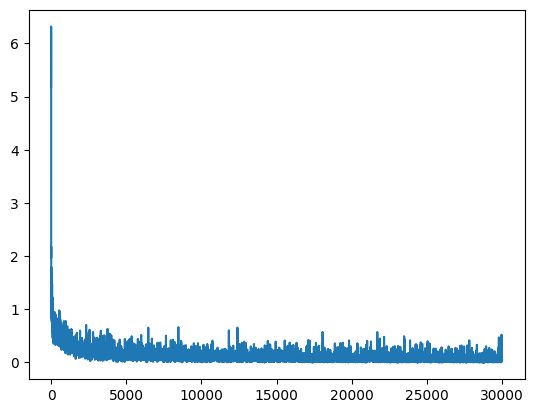

 80%|█████████████████████████████████████████████████████████████▌               | 7999/10000 [10:40<02:28, 13.45it/s]

Loss at 40000 = 0.02716762013733387


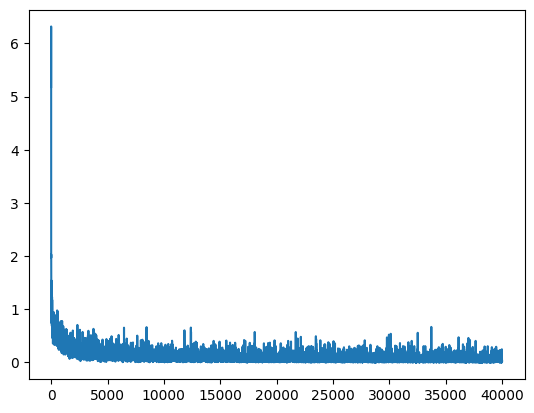

100%|████████████████████████████████████████████████████████████████████████████▉| 9998/10000 [13:18<00:00, 11.61it/s]

Loss at 50000 = 0.06465747952461243


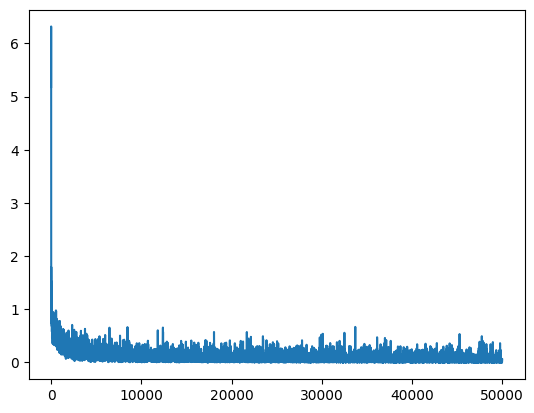

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:19<00:00, 12.52it/s]


In [30]:
C_fake = train(Classifier().cuda(), np.concatenate((X_train, fake_X_train)), np.concatenate((y_train, fake_y_train)), epochs=15000)

In [31]:
test(C_fake, X_test, y_test)

(40706, 103)
(40706,)
              precision    recall  f1-score   support

           1     0.9595    0.9405    0.9499      6302
           2     0.9571    0.9825    0.9696     17756
           3     0.8270    0.8321    0.8296      1977
           4     0.9537    0.9418    0.9477      2906
           5     0.9992    0.9984    0.9988      1273
           6     0.9433    0.8707    0.9056      4819
           7     0.9074    0.8710    0.8888      1271
           8     0.8632    0.8903    0.8766      3502
           9     1.0000    0.9900    0.9950       900

    accuracy                         0.9418     40706
   macro avg     0.9345    0.9242    0.9291     40706
weighted avg     0.9419    0.9418    0.9416     40706



array([8, 8, 1, ..., 2, 2, 2], dtype=int64)